# Error analysis notebook - lambdamart, seed 0, test data

## Import packages

In [47]:
import pandas as pd
import math

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from elasticsearch import Elasticsearch

import warnings
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore")

from enum import IntEnum

from elasticsearch import Elasticsearch
es = Elasticsearch([{'timeout':200}])

import json

# lambdamart, seed=0

## Set filepaths

#### Meta, DocHLevel

In [2]:
ranking = '../evaluation/resources/2020/jsonruns/lambdamart_mrfr_train_90_10_split_lm_ndcg_nofeat_random_state=0.json'

eval_result_eelh = '../evaluation/resources/2020/eval_results/lambdamart_mrfr_train_90_10_split_lm_ndcg_nofeat_random_state=0_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_EEL.tsv'
eval_result_eeli = '../evaluation/resources/2020/eval_results/lambdamart_mrfr_train_90_10_split_lm_ndcg_nofeat_random_state=0_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_ERR.tsv'

gt = '../pre_processing/resources/training/2020/TREC-Fair-Ranking-training-sample.json'
annotations = '../pre_pre_processing/resources/merged-annotations.json'
features = '../pre_processing/resources/escache/lambdamart2020.csv'

## Prepare dataframes

In [3]:
# ranking df
rdf = pd.read_json(ranking, lines=True)
rdf["q_num"]  = rdf.q_num.apply(lambda row: str(row))
rdf = rdf[rdf.q_num.str.contains('.0$')]

# ground truth df
gtdf = pd.read_json(gt, lines=True).explode('documents')
gtdf['doc_id'] = gtdf.documents.apply(lambda row: row.get('doc_id'))
gtdf['doc_rel'] = gtdf.documents.apply(lambda row: row.get('relevance'))

# paired down relevances df
reldf = gtdf[['qid','query','doc_id','doc_rel']]

# eval result dfs
eelh = pd.read_csv(eval_result_eelh, sep='\t', names=['key', 'qid', 'value'])
eelh = eelh.pivot(index='qid', columns='key', values='value')
eelh = eelh.reset_index()

eeli = pd.read_csv(eval_result_eeli, sep='\t', names=['key', 'qid', 'value'])
eeli = eeli.pivot(index='qid', columns='key', values='value')
eeli = eeli.reset_index()

# annotations
adf = pd.read_json(annotations,lines=True)
adf = adf.explode('authors')
adf[['name','wiki','country','type','valid','auth_id', 'h_index','level','region']] = adf.authors.apply(pd.Series).rename({'id':'auth_id'},axis=1)

# features
fdf = pd.read_csv(features)

In [4]:
eeli.mean()

key
qid           39200.950000
difference        1.377774
disparity         1.239142
relevance         0.208356
dtype: float64

In [5]:
eeli.sort_values(by='difference')

key,qid,difference,disparity,relevance
16,66637,0.525955,1.082357,0.669690
17,67404,0.597733,1.083329,0.634288
11,43018,0.610639,1.083333,0.627251
6,20363,0.746339,1.083074,0.455509
12,49766,0.753809,1.067704,0.334379
7,25869,0.854107,1.083318,0.335096
3,12073,0.966255,1.079412,0.137386
14,54003,1.359283,1.270582,0.347054
19,120668,1.416284,1.316670,0.048958
8,27887,1.417139,1.332348,0.004388


In [6]:
eelh.mean()

key
qid           39200.950000
difference        0.761915
disparity         2.154180
relevance         1.242731
dtype: float64

In [7]:
eelh.sort_values(by='difference')

key,qid,difference,disparity,relevance
17,67404,0.010388,1.775892,1.736097
16,66637,0.011306,2.150781,1.995850
14,54003,0.137689,3.004248,2.361411
4,12096,0.177724,2.823221,2.189027
19,120668,0.288219,1.484601,1.157862
3,12073,0.384085,1.385029,0.831051
2,10795,0.464798,2.266611,1.505607
12,49766,0.510208,1.134553,0.632061
18,70673,0.526231,1.541967,0.970678
0,3462,0.577116,2.792294,1.664274


## Error analysis template
For Lambdamart we answer the following questions to gain insight into the points of failure of the ranker.

1. Behavior on top relevant documents  
    - How many of the top documents for this system were relevant and could they be categorized and distinguished from others?
2. Behavior on top non-relevant documents  
    - Why were top non-relevant documents retrieved
3. Behavior on bottom-ranked relevant documents  
    - Why weren't these relevant documents in the top positions
4. What did the system think were the important terms of the original query, and were they good?
5. Is the performance of the system in terms of EEL𝑖𝑛𝑑 or EELℎ mostly due to high disparity, low relevance, or both?
6. What obvious mistakes did the system make that it could have easily avoided?
6. Other features of note.
8. What added information would help performance? How can the system get that information?
9. Are there differences between the official assessment of documents and your own assessment?


## Visualization

### Methods

In [8]:
def extract_results_based_on_qid(qid, ranking_df):
    return ranking_df[ranking_df.qid == qid]

def extract_relevances_based_on_qid(qid, relevance_df):
    return relevance_df[relevance_df.qid == qid]

In [9]:
def count_relgrades(relevance_df):
    rel_counts = relevance_df.doc_rel.value_counts()
    rel_count = rel_counts[1]
    nonrel_count = rel_counts[0]
    return rel_count, nonrel_count

def count_relgrades_qid(qid, relevance):
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    return count_relgrades(subrelevance)


In [10]:
def ranking_to_df(ranking, relevance):
    ranking = ranking[['qid','ranking']].reset_index(drop=True)
    ranking = ranking.explode('ranking')
    ranking['rank'] = ranking.groupby(level=0).cumcount()
    ranking = ranking.reset_index(drop=True)
    ranking = ranking.rename({'ranking':'doc_id'},axis=1)
    merge = pd.merge(ranking,relevance[['qid','doc_id','doc_rel']], on = ['qid', 'doc_id'], how='left')
    merge['rel'] = merge['doc_rel'].apply(lambda row: 'rel' if row == 1 else 'nonrel')
    return merge

In [11]:
def plot_positions(qid, ranking, relevance, title=True):
    data = ranking[ranking.qid == qid]
    # print(data)
    data["doc_labels"] = data.apply(lambda row: f"{row['rank'] + 1}: {row.doc_id[:4]}...", axis=1,result_type='expand')
    
    fig, ax = plt.subplots(1,1,figsize=(9,6))
    sns.scatterplot(data=data, x='doc_labels', y='rel', hue='rel',ax = ax,hue_order= ['rel', 'nonrel'])
    rel = count_relgrades_qid(qid, relevance)[0]
  
    ax.axvline(x=rel - 0.5, color='g')
    ax.set_xticks(np.arange(len(data)))
    if title:
        fig.suptitle(f'Relevant/non-relevant documents for qid {qid}')
    
    ax.set(ylabel=None)
    
    
    ax.set_xticklabels(data.doc_labels.to_list(),rotation = -70)
    ax.get_legend().remove()
        
    

In [12]:
def questions1to3(qid, ranking, relevance, printthese=['toprels','topnrels','botrels']):
    data = ranking[ranking.qid == qid]
    relc, _ = count_relgrades_qid(qid,relevance)
    tops = data.query(f'rank < {relc}')
    bots = data.query(f'rank >= {relc}')
    
#     print(relc)
#     print(tops)
    
    toprels = tops.query('doc_rel == 1').doc_id.to_list()
    topnrels = tops.query('doc_rel == 0').doc_id.to_list()
    botrels = bots.query('doc_rel == 1').doc_id.to_list()
    
    if 'toprels' in printthese:
        print('toprels')
        for d in toprels:
            print(d)
        print()
    
    if 'topnrels' in printthese:
        print('topnrels')
        for d in topnrels:
            print(d)
        print()
    
    if 'botrels' in printthese:
        print('botrels')
        for d in botrels:
            print(d)
        print()
        
    

In [13]:
def compute_count_in_top(qid, ranking, relevance, rel=True):
    data = ranking[ranking.qid == qid]
    # print(data)
    relc, _ = count_relgrades_qid(qid,relevance)
    # print(relc)
    tops = data.query(f'rank < {relc}')
    # print(tops)
    if rel:
        return len(tops.query('doc_rel == 1'))
    else:
        return len(tops.query('doc_rel == 0'))
    
        
    

In [14]:
def compute_percentage_in_top(qid, ranking, relevance, rel=True):
    data = ranking[ranking.qid == qid]
    # print(data)
    relc, _ = count_relgrades_qid(qid,relevance)
    # print(relc)
    tops = data.query(f'rank < {relc}')
    # print(tops)
    if rel:
        return len(tops.query('doc_rel == 1'))/relc
    else:
        return len(tops.query('doc_rel == 0'))/relc

In [16]:
def count_rel_nonrel_per_rank(rankings_df, relevance_df):
    """rankings_df and relevance_df should already be reduced to the information for a single qid"""
    countdict = {k :{'r':0,'nr':0} for k in range(1,len(rankings_df['ranking'].iloc[0]) + 1)}
    for idx, row in rankings_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            rel = relevance_df[relevance_df.doc_id == doc].doc_rel.iloc[0]
            if rel == 0:
                countdict[i+1]['nr'] = countdict[i+1]['nr'] + 1
            elif rel == 1:
                countdict[i+1]['r'] = countdict[i+1]['r'] + 1
            else:
                raise ValueError
    return countdict
            

In [17]:
def rel_nonrel_per_rank_counts_to_sns_df(countdict):
    unpacked = [record for reclist in [[{**{'rank':k},**{'relkind':k2,'count':v2}} for k2,v2 in v.items()] for k,v in countdict.items()] for record in reclist]
    return pd.DataFrame(unpacked)

In [18]:
rankdf = ranking_to_df(rdf,reldf)
rankdf

,qid,doc_id,rank,doc_rel,rel
0,10795,4145a64995792f84d456e62ef83f1404251893c3,0,0,nonrel
1,10795,44856fea7203a7e02f68d5fcc3390f2d44ba8b73,1,0,nonrel
2,10795,4d5251c0520ee6698087ee37864079e19d56b2f8,2,0,nonrel
3,10795,ef7bfa013689524c27370ef7849789b48ff42656,3,1,rel
4,10795,f85bd7fe8f93f31ca95ac7fc79bffd7718172e87,4,0,nonrel
...,...,...,...,...,...
493,20363,98ab45160269f7c1545f7924f989d5da1895e9a5,13,0,nonrel
494,20363,d5781bdf5e310e27acc4ba03a1f01c1f8a951991,14,0,nonrel
495,20363,658dac82a4f292ecd7c631c6a61408db75f05d07,15,0,nonrel
496,20363,ad6de2d9a36f851da4bef2c9f576a24ac502920a,16,0,nonrel


## Visualization

[31412, 30631, 27887, 8940, 51432, 20363, 25869, 64062, 43018, 12828]


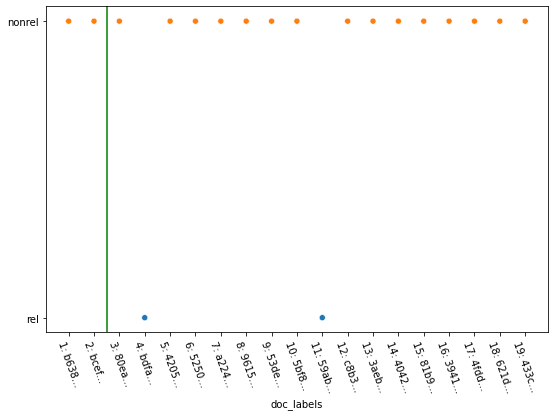

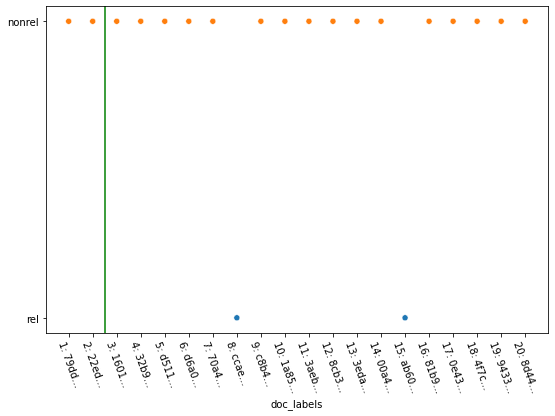

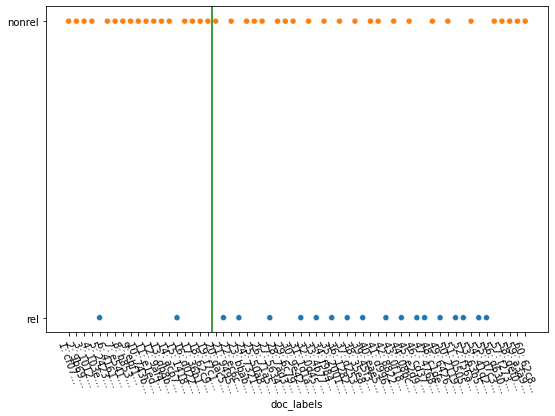

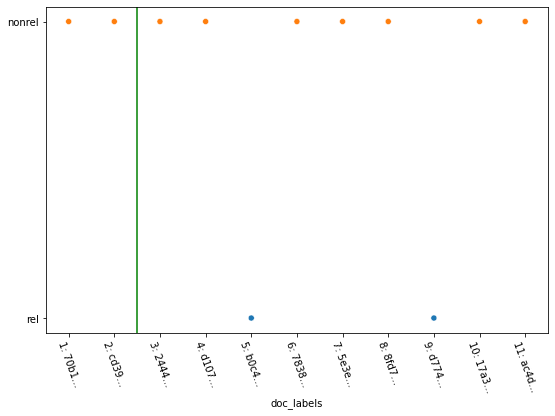

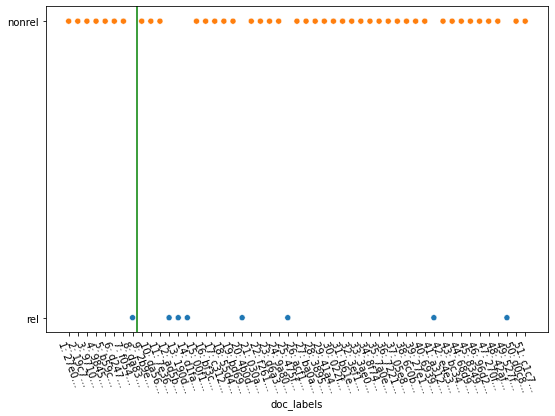

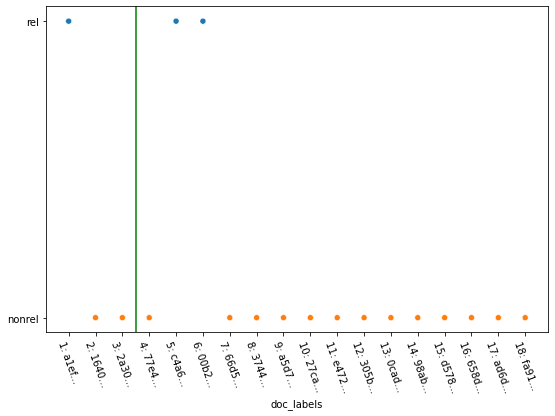

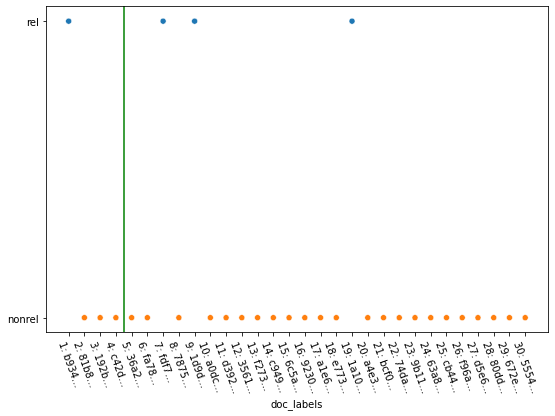

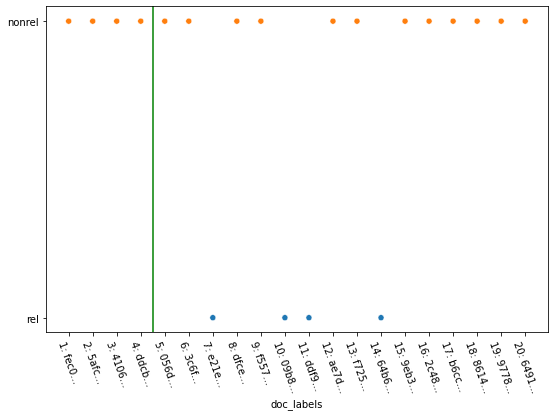

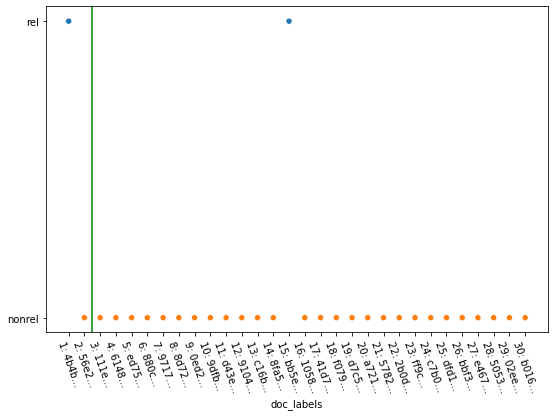

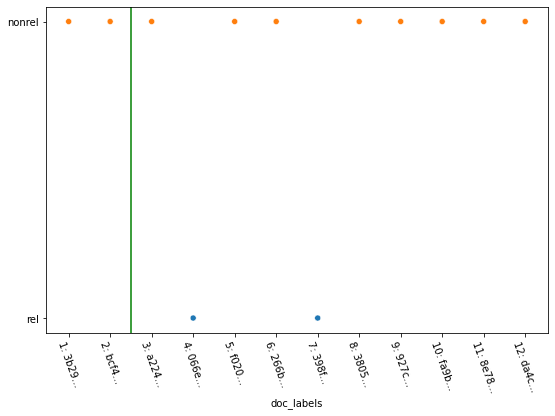

In [19]:
n = 10
print(eelh.sort_values(by='difference',ascending=False).qid.to_list()[:n])
for q in eelh.sort_values(by='difference',ascending=False).qid.to_list()[:n]:
    plot_positions(q,rankdf,rankdf,title=False)

[30631, 12096, 8940, 31412, 12828, 64062, 70673, 3462, 10795, 51432]


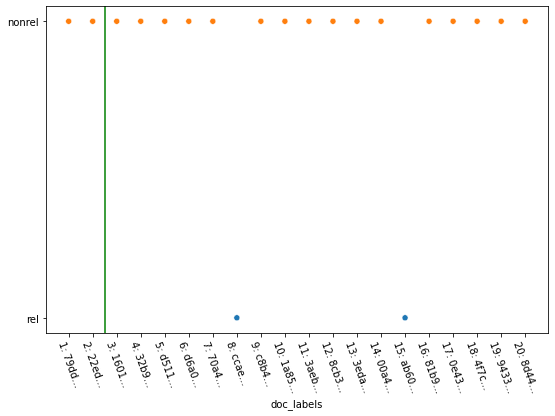

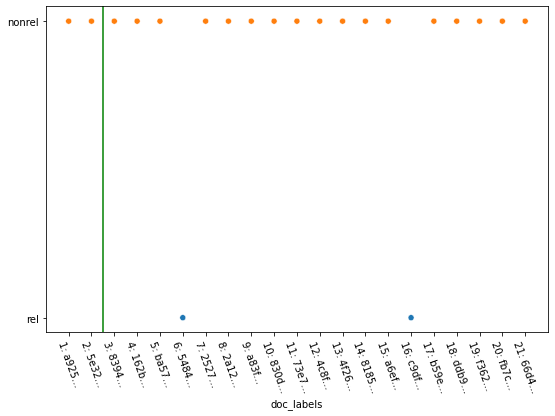

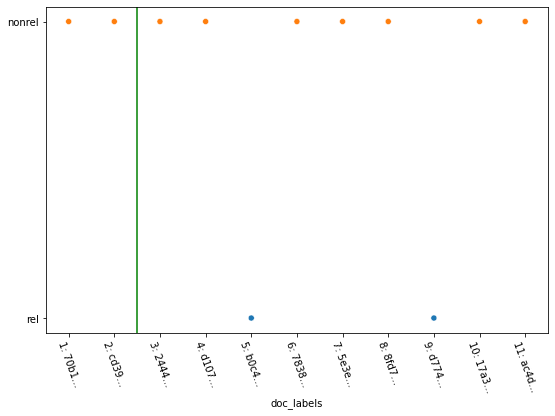

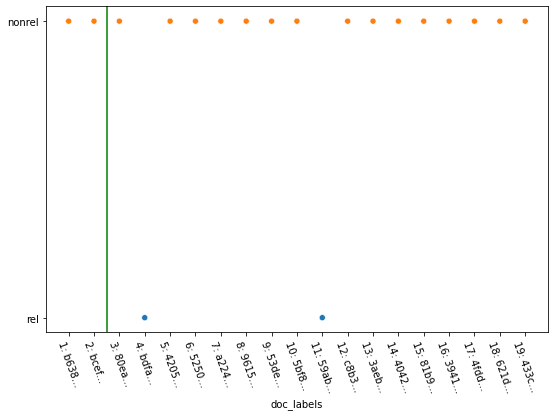

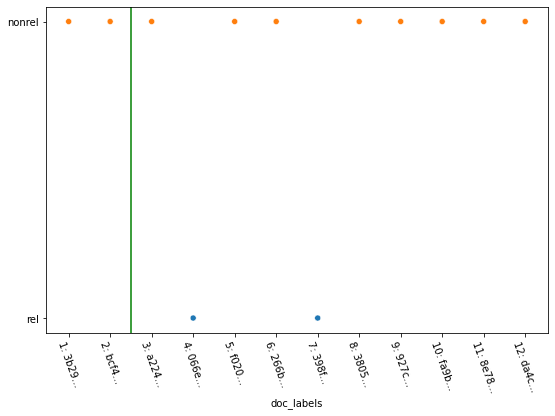

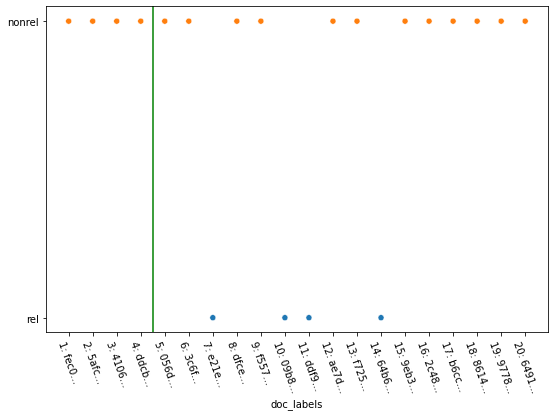

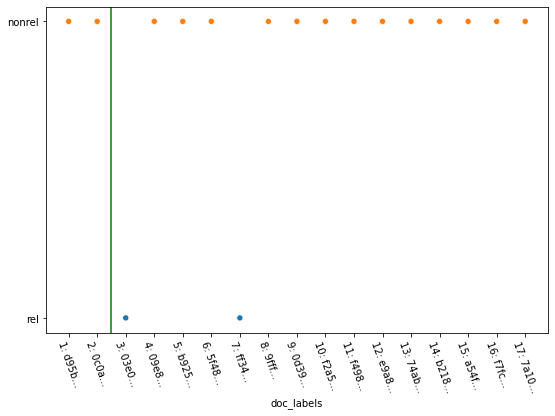

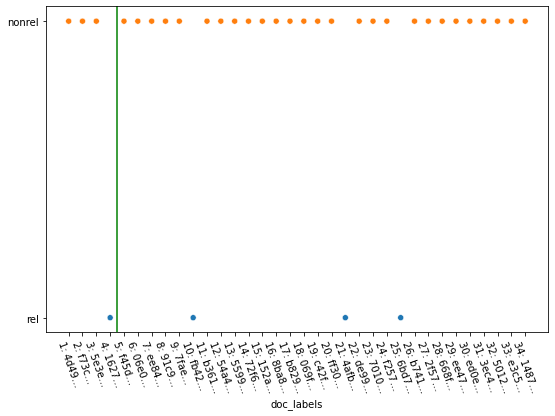

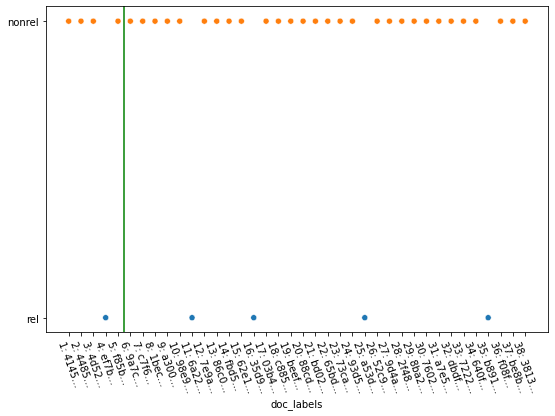

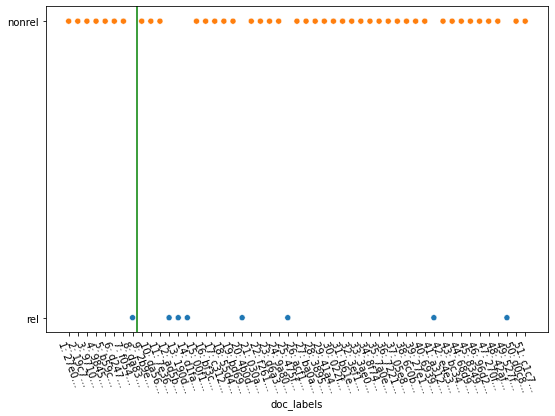

In [20]:
s = 0
n = 10
print(eeli.sort_values(by='difference',ascending=False).qid.to_list()[s:n])
for q in eeli.sort_values(by='difference',ascending=False).qid.to_list()[s:n]:
    plot_positions(q,rankdf,reldf,title=False)

## 1.How many of the top documents are relevant and can they be distinguished?

### EELH

#### percentage/counts


In [21]:
n=10
c=0
p=0
for q in eelh.sort_values(by='difference',ascending=False).qid.to_list()[:n]:
   
    c += compute_count_in_top(q,rankdf,reldf)
    p += compute_percentage_in_top(q,rankdf,reldf)
print(round(c/n,2))
print(round(p/n,2))

0.6
0.13


In [22]:
n=10
for q in eelh.sort_values(by='difference',ascending=False).qid.to_list()[:n]:
    print(q)
    questions1to3(q,rankdf,reldf,'toprels')
    print()

31412
toprels


30631
toprels


27887
toprels
2423ea8cf66765d79363988086bf0f6066a13872
14187497d25732666bd05185037f6048fc5fef8c


8940
toprels


51432
toprels
da83d41292b0357131bc70f6f6e94993103cd9e9


20363
toprels
a1efc262f96d83b91986cfef14f34b7488230f67


25869
toprels
b934f259f93a1ec6f3449def5d77da24e8565276


64062
toprels


43018
toprels
4b4b63405efd22a96cc45b22c08124d62a475d6f


12828
toprels




#### 27887

In [23]:
reldf.query('qid == 27887')[['query']].drop_duplicates()

,query
188,beauty


In [24]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['2423ea8cf66765d79363988086bf0f6066a13872','14187497d25732666bd05185037f6048fc5fef8c']}}})
res

{'took': 2676,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 2, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '2423ea8cf66765d79363988086bf0f6066a13872',
    '_score': 1.0,
    '_source': {'title': 'The Beauty of Measurements',
     'paperAbstract': 'Purpose – There is a clear focus upon increasing research output, improving research quality and securing closer interaction between universities and the private market of businesses. Research should be evaluated according to usefulness and relevant criteria, where increased competition between universities and business schools for research grants should be established, such that the greatest number of publications, with the highest impact factors and most citations trigger most funding. Measurements and rankings have become hot topics for universities and business schools – this paper aims t

##### remarks
Has the query in the title

#### 51432

In [25]:
reldf.query('qid == 51432')[['query']].drop_duplicates()

,query
187,text mining


In [26]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['da83d41292b0357131bc70f6f6e94993103cd9e9']}}})
res

{'took': 1746,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': 'da83d41292b0357131bc70f6f6e94993103cd9e9',
    '_score': 1.0,
    '_source': {'title': "Analysing competitors' online persuasive themes with text mining",
     'paperAbstract': "Information is power. Cliche, but true. The Internet has simultaneously empowered individuals. Prospects can click, choose and control their online interactions. For organisations, the pendulum has swung in the opposite direction. They face more competition and are overloaded with more information than ever before. Manual tracking and processing of competitor activity are tedious, inaccurate, and rapidly outdated. Technology has created the “problem”, and technology can offer potential solutions. This study explores the use of text mining technology to an

##### remarks
occurs in title and body 1 to 1

#### 20363
toprels
a1efc262f96d83b91986cfef14f34b7488230f67


In [27]:
reldf.query('qid == 51432')[['query']].drop_duplicates()

,query
187,text mining


In [28]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['da83d41292b0357131bc70f6f6e94993103cd9e9']}}})
res

{'took': 2,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': 'da83d41292b0357131bc70f6f6e94993103cd9e9',
    '_score': 1.0,
    '_source': {'title': "Analysing competitors' online persuasive themes with text mining",
     'paperAbstract': "Information is power. Cliche, but true. The Internet has simultaneously empowered individuals. Prospects can click, choose and control their online interactions. For organisations, the pendulum has swung in the opposite direction. They face more competition and are overloaded with more information than ever before. Manual tracking and processing of competitor activity are tedious, inaccurate, and rapidly outdated. Technology has created the “problem”, and technology can offer potential solutions. This study explores the use of text mining technology to analy

##### remarks
occurs in title and body 1 to 1

#### 25869
toprels
b934f259f93a1ec6f3449def5d77da24e8565276

In [29]:
reldf.query('qid == 25869')[['query']].drop_duplicates()

,query
196,environmental art


In [30]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['b934f259f93a1ec6f3449def5d77da24e8565276']}}})
res

{'took': 847,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': 'b934f259f93a1ec6f3449def5d77da24e8565276',
    '_score': 1.0,
    '_source': {'title': 'Art Nature Dialogues Interviews With Environmental Artists',
     'paperAbstract': 'Thank you for reading art nature dialogues interviews with environmental artists. As you may know, people have search hundreds times for their chosen readings like this art nature dialogues interviews with environmental artists, but end up in infectious downloads. Rather than reading a good book with a cup of coffee in the afternoon, instead they cope with some infectious virus inside their desktop computer.',
     'entities': [],
     'author_names': ['Laura Strauss'],
     'author_ids': ['46561023'],
     'inCitations': 6,
     'outCitations': 0,
     'year': 

##### remarks
occurs in title and body partially, in the text it's artists so plural, words are next to each other

#### 43018
toprels
4b4b63405efd22a96cc45b22c08124d62a475d6f

In [31]:
reldf.query('qid == 43018')[['query']].drop_duplicates()

,query
181,data security medicine


In [32]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['4b4b63405efd22a96cc45b22c08124d62a475d6f']}}})
res

{'took': 903,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '4b4b63405efd22a96cc45b22c08124d62a475d6f',
    '_score': 1.0,
    '_source': {'title': 'Big healthcare data: preserving security and privacy',
     'paperAbstract': 'Big data has fundamentally changed the way organizations manage, analyze and leverage data in any industry. One of the most promising fields where big data can be applied to make a change is healthcare. Big healthcare data has considerable potential to improve patient outcomes, predict outbreaks of epidemics, gain valuable insights, avoid preventable diseases, reduce the cost of healthcare delivery and improve the quality of life in general. However, deciding on the allowable uses of data while preserving security and patient’s right to privacy is a difficult task. Bi

##### remarks
all separate words occur one or more times

### EELI

#### percentage/counts


In [33]:
n=10
c=0
p=0
for q in eeli.sort_values(by='difference',ascending=False).qid.to_list()[:n]:
   
    c += compute_count_in_top(q,rankdf,reldf)
    p += compute_percentage_in_top(q,rankdf,reldf)
print(round(c/n,2))
print(round(p/n,2))

0.3
0.06


In [34]:
n=10
for q in eeli.sort_values(by='difference',ascending=False).qid.to_list()[:n]:
    print(q)
    questions1to3(q,rankdf,reldf,'toprels')
    print()

30631
toprels


12096
toprels


8940
toprels


31412
toprels


12828
toprels


64062
toprels


70673
toprels


3462
toprels
16275e5e070de5dd097b2bb0d6204f0f8e5538a3


10795
toprels
ef7bfa013689524c27370ef7849789b48ff42656


51432
toprels
da83d41292b0357131bc70f6f6e94993103cd9e9




#### 51432

In [35]:
reldf.query('qid == 51432')[['query']].drop_duplicates()

,query
187,text mining


In [36]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['da83d41292b0357131bc70f6f6e94993103cd9e9']}}})
res

{'took': 3,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': 'da83d41292b0357131bc70f6f6e94993103cd9e9',
    '_score': 1.0,
    '_source': {'title': "Analysing competitors' online persuasive themes with text mining",
     'paperAbstract': "Information is power. Cliche, but true. The Internet has simultaneously empowered individuals. Prospects can click, choose and control their online interactions. For organisations, the pendulum has swung in the opposite direction. They face more competition and are overloaded with more information than ever before. Manual tracking and processing of competitor activity are tedious, inaccurate, and rapidly outdated. Technology has created the “problem”, and technology can offer potential solutions. This study explores the use of text mining technology to analy

##### remarks
occurs in title and body 1 to 1

#### 3462
toprels
16275e5e070de5dd097b2bb0d6204f0f8e5538a3


In [37]:
reldf.query('qid == 3462')[['query']].drop_duplicates()

,query
197,management


In [38]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['16275e5e070de5dd097b2bb0d6204f0f8e5538a3']}}})
res

{'took': 541,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '16275e5e070de5dd097b2bb0d6204f0f8e5538a3',
    '_score': 1.0,
    '_source': {'title': 'Project management.',
     'paperAbstract': 'PROJECT PROFILE Project Management Improves Lenovo’s Bottom Line INTRODUCTION 2.1 PROJECTS AND ORGANIZATIONAL STRATEGY 2.2 STAKEHOLDER MANAGEMENT Identifying Project Stakeholders Managing Stakeholders 2.3 ORGANIZATIONAL STRUCTURE 2.4 FORMS OF ORGANIZATIONAL STRUCTURE Functional Organizations Project Organizations Matrix Organizations Moving to Heavyweight Project Organizations PROJECT MANAGEMENT RESEARCH IN BRIEF The Impact of Organizational Structure on Project Performance 2.5 PROJECT MANAGEMENT OFFICES 2.6 ORGANIZATIONAL CULTURE How Do Cultures Form? Organizational Culture and Project Management PR

##### remarks
occurs in title, body, venue, AND journalname in its entirety  
paperAbstract lookst to be the outline of a book

does look pretty useful!

#### 10795
toprels
ef7bfa013689524c27370ef7849789b48ff42656

In [39]:
reldf.query('qid == 10795')[['query']].drop_duplicates()

,query
180,truth


In [40]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['ef7bfa013689524c27370ef7849789b48ff42656']}}})
res

{'took': 632,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': 'ef7bfa013689524c27370ef7849789b48ff42656',
    '_score': 1.0,
    '_source': {'title': 'The truth, the whole truth, and nothing but the truth',
     'paperAbstract': "While avoiding relativism, Rorty claims that: (1) truth is just for a time and a place; (2) ‘truth’ and ‘rationality’ are indexed to a community's standards of warranted assertibility; and (3) there is nothing more to be said about truth and rationality than is contained, in a community's procedures for evaluating claims. He makes these assertions because he believes that the cautionary uses of ‘true’ and ‘rational’ crucially depend upon the endorsing uses of these terms. I argue that Rorty is wrong in this belief and that the principle of charity assures us that in 

##### remarks
all occurs in title and abstract

In [41]:
# print(eelh.sort_values(by='difference').qid.to_list())
print(eeli.sort_values(by='difference').qid.to_list())

[66637, 67404, 43018, 20363, 49766, 25869, 12073, 54003, 120668, 27887, 51432, 10795, 3462, 70673, 64062, 12828, 31412, 8940, 12096, 30631]


In [42]:
for qid in eeli.sort_values(by='difference').qid.to_list():
    print(qid,reldf.query(f'qid == {qid}').iloc[0].query)

66637 graduate record examination
67404 information needs and uses
43018 data security medicine
20363 uncanny valley
49766 regulatory compliance
25869 environmental art
12073 iot
54003 yoghurt
120668 celtic knot
27887 beauty
51432 text mining
10795 truth
3462 management
70673 family honor
64062 dover beach
12828 covid-19 renal
31412 covid vaccines
8940 fourier
12096 molecular selection for rice of ssr
30631 covid-19 testing


66637 is the 

In [43]:
list(filter(lambda x: x.startswith('4b4b') or x.startswith('56e2') or x.startswith('111e') or x.startswith('bb5e'), list(set(reldf.doc_id.to_list()))))

['111e7daa3c579208ba80c23ac33ab7e7b5b1f099',
 'bb5e388aa3c9d593f5d27bde0180895f1c329898',
 '4b4b63405efd22a96cc45b22c08124d62a475d6f',
 '56e2e7643ac3a9832d14ade7d868892ed544fa90']

In [44]:
es = Elasticsearch()

In [50]:
eelif = fdf[fdf.qid.isin(eeli.sort_values(by="difference").qid.to_list())]
eelif

,qid,title_score,abstract_score,entities_score,venue_score,journal_score,authors_score,year,inCitations,outCitations,doc_id,qlength
152,10795,11.784700,0.000000,0.0,0.0,0.0,0.0,2009.0,86.0,0.0,7e9a1a27d9a965e002f510565c8bc94399d9f3fd,5
153,10795,10.299318,0.000000,0.0,0.0,0.0,0.0,1999.0,310.0,0.0,8ba23fd8548177727fcdd6c5bf45ae6d4b8cda48,5
154,10795,9.884047,7.572024,0.0,0.0,0.0,0.0,2004.0,274.0,1.0,52c9e15facda9999e54b8876d8ad5f2edd885d9f,5
155,10795,13.075858,0.000000,0.0,0.0,0.0,0.0,2005.0,7.0,0.0,c7f6a6728adfa3d29327384bdfedb297ccff3613,5
156,10795,9.884047,0.000000,0.0,0.0,0.0,0.0,2016.0,38.0,0.0,a3006b4e72ca92746d358eb0d0896cb2e74223b9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4410,8940,9.450779,9.760600,0.0,0.0,0.0,0.0,1982.0,848.0,7.0,17a3a7735cafe32d337e7b8ed17dfa4ff0f09680,7
4411,8940,9.450779,9.271596,0.0,0.0,0.0,0.0,1996.0,485.0,22.0,d774b8b767eb53873e0dd0ea4bfaa7744fabcb31,7
4412,8940,10.751263,7.501965,0.0,0.0,0.0,0.0,1968.0,5809.0,0.0,5e3eb22c476b889eecbb380d012231d819edf156,7
4413,8940,9.450779,0.000000,0.0,0.0,0.0,0.0,2011.0,870.0,0.0,24446ed4c3d12341406b213e58136ad54c706d69,7


In [51]:
qid = 66637
docids = ['dea6c3948efcb63da1dd103013fa6d5bb82cf281','32120fcbe7d858fe61b5ebc589983e9b015a060a','a0eb1f063cb91f1797f22e6c59727c52eb827e1e','ee80feb04470103fa08ff2c06d24e1418171ea92']
print(qid, reldf.query(f'qid == {qid}').iloc[0].query)

res = es.search(index='semanticscholar2020og', body={'query':{'ids':{'values':docids}}})
print(json.dumps(res['hits']['hits'],indent=2))

eelif.query(f'qid == {qid}')[eelif.doc_id.isin(docids)]

66637 graduate record examination
[
  {
    "_index": "semanticscholar2020og",
    "_type": "document",
    "_id": "a0eb1f063cb91f1797f22e6c59727c52eb827e1e",
    "_score": 1.0,
    "_source": {
      "title": "Reflections on The Graduate Record Examination",
      "paperAbstract": "The graduate record examination is the foundation and guarantee of students' quality.In this paper,mathematical statistics is used to analyze the grades of basic and major courses from 2004 to 2006 in China Agriculture University,so as to detect the reasonability of the test papers,according to which scientific adjustment advices are proposed.Through comparison of entrance grades and after-enrollment comprehensive quality assessment,the impact factors influencing the overall quality is estimated quantitatively.Finally,scientific enrollment suggestions are proposed.",
      "entities": [],
      "author_names": [
        "Gong Weiwei"
      ],
      "author_ids": [
        "46532406"
      ],
      "inCitati

,qid,title_score,abstract_score,entities_score,venue_score,journal_score,authors_score,year,inCitations,outCitations,doc_id,qlength
3538,66637,27.575043,19.607350,0.0,0.0,0.0,0.0,2007.0,0.0,0.0,a0eb1f063cb91f1797f22e6c59727c52eb827e1e,27
3539,66637,26.463207,0.000000,0.0,0.0,0.0,0.0,2009.0,1.0,0.0,ee80feb04470103fa08ff2c06d24e1418171ea92,27
3543,66637,27.575043,23.240059,0.0,0.0,0.0,0.0,2010.0,0.0,0.0,32120fcbe7d858fe61b5ebc589983e9b015a060a,27
3546,66637,30.104704,5.149076,0.0,0.0,0.0,0.0,2016.0,0.0,0.0,dea6c3948efcb63da1dd103013fa6d5bb82cf281,27


In [52]:
qid = 67404
docids = ['03f8ca128fa4e9a4f5b9f2f211c0fc9f2793fb3c','a2addbd0461e95e907797a4304b7e4d43dff9d0f','38dd11deaadd13d2c21904ae2bdf9789f6cfbbbb','c402314407034f3670ce1db0a41d07cee0349a1e']
print(qid, reldf.query(f'qid == {qid}').iloc[0].query)

res = es.search(index='semanticscholar2020og', body={'query':{'ids':{'values':docids}}})
print(json.dumps(res['hits']['hits'],indent=2))

eelif.query(f'qid == {qid}')[eelif.doc_id.isin(docids)]

67404 information needs and uses
[
  {
    "_index": "semanticscholar2020og",
    "_type": "document",
    "_id": "03f8ca128fa4e9a4f5b9f2f211c0fc9f2793fb3c",
    "_score": 1.0,
    "_source": {
      "title": "Information Needs and Uses",
      "paperAbstract": "The user is an important component in any information system. To create information awareness and to promote the use of information, it is necessary to know the needs of the users. Assessment of user needs has been developed by the present age of information explosions. According to Ranganathan\u2019s fifth law of library science, library is a growing organism. As the growth of library is based on the satisfaction of the users, the views of the users are necessary to develop the library facilities and services. Surveying the user needs is helpful to find out the requirements of the users. The extent of usage of the existing library resources and the ways and means to increase the utilization are studied.",
      "entities": [],

,qid,title_score,abstract_score,entities_score,venue_score,journal_score,authors_score,year,inCitations,outCitations,doc_id,qlength
3608,67404,29.223090,12.028270,0.0,0.0,0.0,0.0,2013.0,10.0,0.0,03f8ca128fa4e9a4f5b9f2f211c0fc9f2793fb3c,26
3613,67404,16.903605,10.516714,0.0,0.0,0.0,0.0,1981.0,761.0,17.0,c402314407034f3670ce1db0a41d07cee0349a1e,26
3614,67404,22.120592,15.375030,0.0,0.0,0.0,0.0,2004.0,161.0,10.0,38dd11deaadd13d2c21904ae2bdf9789f6cfbbbb,26
3615,67404,29.223090,0.000000,0.0,0.0,0.0,0.0,1968.0,52.0,0.0,a2addbd0461e95e907797a4304b7e4d43dff9d0f,26


In [53]:
qid = 43018
docids = ['4b4b63405efd22a96cc45b22c08124d62a475d6f',
 '56e2e7643ac3a9832d14ade7d868892ed544fa90',
 '111e7daa3c579208ba80c23ac33ab7e7b5b1f099',
 'bb5e388aa3c9d593f5d27bde0180895f1c329898']
print(qid, reldf.query(f'qid == {qid}').iloc[0].query)

res = es.search(index='semanticscholar2020og', body={'query':{'ids':{'values':docids}}})
print(json.dumps(res['hits']['hits'],indent=2))

eelif.query(f'qid == {qid}')[eelif.doc_id.isin(docids)]

43018 data security medicine
[
  {
    "_index": "semanticscholar2020og",
    "_type": "document",
    "_id": "bb5e388aa3c9d593f5d27bde0180895f1c329898",
    "_score": 1.0,
    "_source": {
      "title": "Security applications of terahertz technology",
      "paperAbstract": "Recent events have accelerated the quest for ever more effective security screening to detect an increasing variety of threats. Many techniques employing different parts of the electromagnetic spectrum from radio up to X- and gammaray are in use. Terahertz radiation, which lies between microwave and infrared, is the last part to be exploited for want, until recently, of suitable sources and detectors. This paper describes practical techniques for Terahertz imaging and spectroscopy which are now being applied to a variety of applications. We describe a number of proof-of-principle experiments which show that Terahertz imaging has the ability to use very low levels of this non-ionising radiation to detect hidden ob

,qid,title_score,abstract_score,entities_score,venue_score,journal_score,authors_score,year,inCitations,outCitations,doc_id,qlength
2312,43018,8.240202,6.378588,0.0,0.00000,0.000000,0.0,2003.0,264.0,0.0,bb5e388aa3c9d593f5d27bde0180895f1c329898,22
2325,43018,13.494258,11.196566,0.0,0.00000,0.000000,0.0,2017.0,30.0,116.0,56e2e7643ac3a9832d14ade7d868892ed544fa90,22
2328,43018,13.176344,11.296127,0.0,6.46427,6.731693,0.0,2017.0,35.0,40.0,4b4b63405efd22a96cc45b22c08124d62a475d6f,22
2330,43018,12.950165,16.720396,0.0,0.00000,0.000000,0.0,2018.0,19.0,21.0,111e7daa3c579208ba80c23ac33ab7e7b5b1f099,22


In [62]:
temp = eelh.sort_values(by='difference').reset_index(drop=True).reset_index()
temp

key,index,qid,difference,disparity,relevance
0,0,67404,0.010388,1.775892,1.736097
1,1,66637,0.011306,2.150781,1.995850
2,2,54003,0.137689,3.004248,2.361411
3,3,12096,0.177724,2.823221,2.189027
4,4,120668,0.288219,1.484601,1.157862
5,5,12073,0.384085,1.385029,0.831051
6,6,10795,0.464798,2.266611,1.505607
7,7,49766,0.510208,1.134553,0.632061
8,8,70673,0.526231,1.541967,0.970678
9,9,3462,0.577116,2.792294,1.664274


<AxesSubplot:>

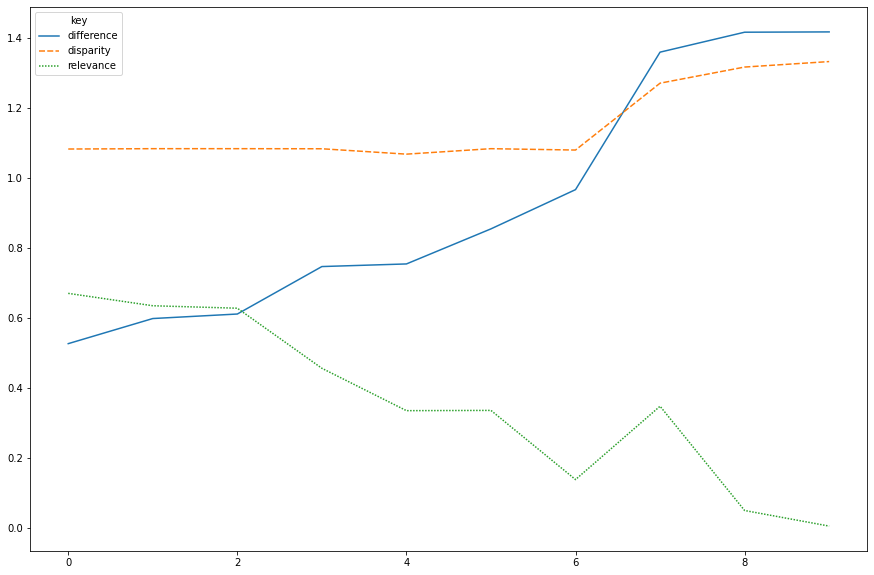

In [70]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.lineplot(data=temp[['difference','disparity','relevance']][:10],ax=ax)

In [63]:
temp = eeli.sort_values(by='difference').reset_index(drop=True).reset_index()
temp

key,index,qid,difference,disparity,relevance
0,0,66637,0.525955,1.082357,0.669690
1,1,67404,0.597733,1.083329,0.634288
2,2,43018,0.610639,1.083333,0.627251
3,3,20363,0.746339,1.083074,0.455509
4,4,49766,0.753809,1.067704,0.334379
5,5,25869,0.854107,1.083318,0.335096
6,6,12073,0.966255,1.079412,0.137386
7,7,54003,1.359283,1.270582,0.347054
8,8,120668,1.416284,1.316670,0.048958
9,9,27887,1.417139,1.332348,0.004388


<AxesSubplot:>

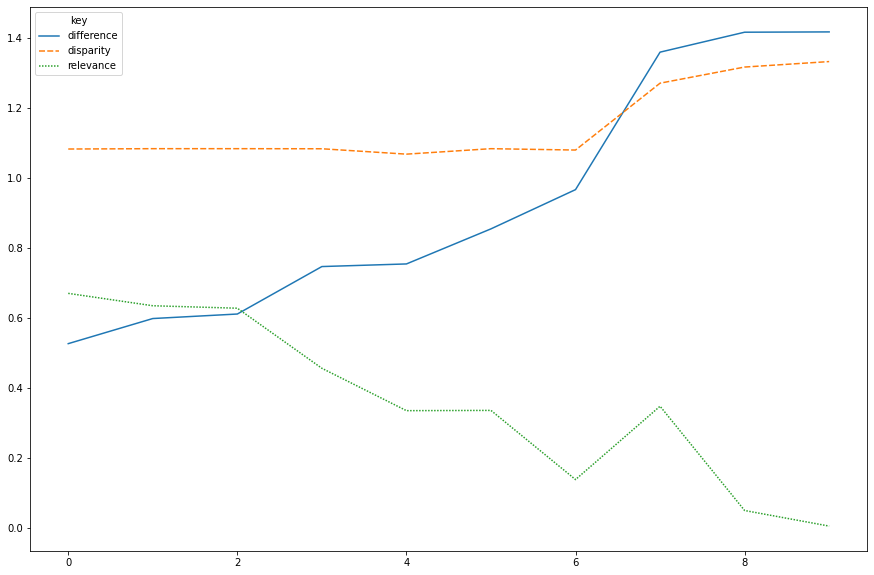

In [71]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.lineplot(data=temp[['difference','disparity','relevance']][:10],ax=ax)

We take the top 10 queries as easy and the bottom as difficult, there is only a sharp increase at the end. (not somehwere in the middle)

## 2. Behavior on top non-relevant documents  


### EELH

In [56]:
n=10
for q in eelh.sort_values(by='difference',ascending=False).qid.to_list()[:n]:
    print(q)
    questions1to3(q,rankdf,reldf,'topnrels')
    print()

31412
topnrels
b638d404a28a56d5553e84bea7450712f5cf00ba
bcefce5aef53be840a92db6302aff0b477daefa3


30631
topnrels
79ddbeff892277592aa387045692e0a738ef9edf
22edc9d8bb18253cdbb7905492c73387b4aee8c4


27887
topnrels
cf07caaea75ca856cd134efb1fe779cf843c705d
9b6933afed989da0b63f29d92e26b00e7fd6f67b
10125cf897aeacdbf832e4151d601bc6d01efc5d
103ef183269304e7098f8b292bf0cdea08f3f1a6
41611ed18848a762e9213f687fda6610b867911e
e541ad97e2774225767e531268c926effe1ff48b
b853137f816585a52fa58144fd2fc4379e7457a8
ebf187757be5efd3573927fcb32f531611b78922
743bc46f3db60cdbb461f455f5f55ea525155efd
e1ed40d9468b840f12c4b36ba31b085a27d0db70
9af4c179704617b8141f6099a01c908cc6def4d9
db8bc3a55ba2d20c104ce640cb831c100d0cca56
acb74e2bdcb60ac1b62d41d0b172afe5f0ab8e36
d02256277cd349c75ba40ba5bd370ec43099c7b0
36b12792a25712f4a7aa578360a6d89fffad0cea
62c9dea87b649020f927870553d183e3e4cd373a
f7c1314b6e82a5b95b0f82f83dd8e9117ba9d412


8940
topnrels
70b187ac64e899219660684f25f1df1c78497ab8
cd3986ad19bcd24824a579486b4e550ad

#### 31412
topnrels
b638d404a28a56d5553e84bea7450712f5cf00ba


bcefce5aef53be840a92db6302aff0b477daefa3


In [57]:
reldf.query('qid == 31412')[['query']].drop_duplicates()

,query
194,covid vaccines


In [58]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['b638d404a28a56d5553e84bea7450712f5cf00ba','bcefce5aef53be840a92db6302aff0b477daefa3']}}})
res

{'took': 1011,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 2, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': 'bcefce5aef53be840a92db6302aff0b477daefa3',
    '_score': 1.0,
    '_source': {'title': 'Research and Development on Therapeutic Agents and Vaccines for COVID-19 and Related Human Coronavirus Diseases',
     'paperAbstract': 'Since the outbreak of the novel coronavirus disease COVID-19, caused by the SARS-CoV-2 virus, this disease has spread rapidly around the globe. Considering the potential threat of a pandemic, scien...',
     'entities': [],
     'author_names': ['C. T. Liu',
      'Qiongqiong Zhou',
      'Yingzhu Li',
      'Linda V. Garner',
      'Steve P. Watkins',
      'Linda J. Carter',
      'Jeffrey W Smoot',
      'Anne C. Gregg',
      'Angela D. Daniels',
      'Susan R Jervey',
      'Dana Albaiu'],
     'author_

##### remarks
whole words

#### 30631
topnrels
79ddbeff892277592aa387045692e0a738ef9edf
22edc9d8bb18253cdbb7905492c73387b4aee8c4


In [59]:
reldf.query('qid == 30631')[['query']].drop_duplicates()

,query
186,covid-19 testing


In [60]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['79ddbeff892277592aa387045692e0a738ef9edf','22edc9d8bb18253cdbb7905492c73387b4aee8c4']}}})
res

{'took': 1363,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 2, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '22edc9d8bb18253cdbb7905492c73387b4aee8c4',
    '_score': 1.0,
    '_source': {'title': 'Visual Data Analysis and Simulation Prediction for COVID-19.',
     'paperAbstract': 'The COVID-19 (formerly, 2019-nCoV) epidemic has become a global health emergency, as such, WHO declared PHEIC. China has taken the most hit since the outbreak of the virus, which could be dated as far back as late November by some experts. It was not until January 23rd that the Wuhan government finally recognized the severity of the epidemic and took a drastic measure to curtain the virus spread by closing down all transportation connecting the outside world. In this study, we seek to answer a few questions: How did the virus get spread from the epicenter Wuh

##### remarks
whole words including punctuation,
not ALL words occur!

#### 27887
topnrels
cf07caaea75ca856cd134efb1fe779cf843c705d
9b6933afed989da0b63f29d92e26b00e7fd6f67b
10125cf897aeacdbf832e4151d601bc6d01efc5d
103ef183269304e7098f8b292bf0cdea08f3f1a6
41611ed18848a762e9213f687fda6610b867911e
e541ad97e2774225767e531268c926effe1ff48b
b853137f816585a52fa58144fd2fc4379e7457a8
ebf187757be5efd3573927fcb32f531611b78922
743bc46f3db60cdbb461f455f5f55ea525155efd
e1ed40d9468b840f12c4b36ba31b085a27d0db70
9af4c179704617b8141f6099a01c908cc6def4d9
db8bc3a55ba2d20c104ce640cb831c100d0cca56
acb74e2bdcb60ac1b62d41d0b172afe5f0ab8e36
d02256277cd349c75ba40ba5bd370ec43099c7b0
36b12792a25712f4a7aa578360a6d89fffad0cea
62c9dea87b649020f927870553d183e3e4cd373a
f7c1314b6e82a5b95b0f82f83dd8e9117ba9d412

In [ ]:
reldf.query('qid == 27887')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 17, "query": {"ids" : {"values" : ['cf07caaea75ca856cd134efb1fe779cf843c705d',
                                                                                              '9b6933afed989da0b63f29d92e26b00e7fd6f67b',
                                                                                              '10125cf897aeacdbf832e4151d601bc6d01efc5d',
                                                                                              '103ef183269304e7098f8b292bf0cdea08f3f1a6',
                                                                                              '41611ed18848a762e9213f687fda6610b867911e',
                                                                                              'e541ad97e2774225767e531268c926effe1ff48b',
                                                                                              'b853137f816585a52fa58144fd2fc4379e7457a8',
                                                                                              'ebf187757be5efd3573927fcb32f531611b78922',
                                                                                              '743bc46f3db60cdbb461f455f5f55ea525155efd',
                                                                                              'e1ed40d9468b840f12c4b36ba31b085a27d0db70',
                                                                                              '9af4c179704617b8141f6099a01c908cc6def4d9',
                                                                                              'db8bc3a55ba2d20c104ce640cb831c100d0cca56',
                                                                                              'acb74e2bdcb60ac1b62d41d0b172afe5f0ab8e36',
                                                                                              'd02256277cd349c75ba40ba5bd370ec43099c7b0',
                                                                                              '36b12792a25712f4a7aa578360a6d89fffad0cea',
                                                                                              '62c9dea87b649020f927870553d183e3e4cd373a',
                                                                                              'f7c1314b6e82a5b95b0f82f83dd8e9117ba9d412']}}})
res

##### remarks
whole word occurs in title or abstract
- question with large number of top positions
- generic search term, multiple interpretations possible
- some of these "nonrels" should be rels in my pov


#### 8940
topnrels
70b187ac64e899219660684f25f1df1c78497ab8
cd3986ad19bcd24824a579486b4e550ad69faaa5


51432
topnrels
27e0dcd372c11ba9a67c210e85125ce8e7cb7663
19c7aa36737e55da3e1ad0a29bf0dd21bb8cbc9f
9710a381fd9155e03efd88c2df3d7f0ecf2794a9
984585dedd6c3907063d04f94ac9c385be633641
b59c510a14907e7fedf2ddcfd756d30086e634f4
d247662d78f06e40b0a3f3470a7780025a6a1c62
f0549ac8da3a3b5873242eb44af3c9cb9ebc84a2


20363
topnrels
1640413b9e31b2fd4316531c75aaccdba1af4431
2a309b3881eba659bf52fb7d1d54fe08f06b1018


25869
topnrels
81b88f3ca681160d4b5b5e2c750617c4fae0c9ed
192bc62a5bffb2994fc620827bd43d6190484c60
c42d8a7009aa9ff2460c381851b2868dc6855ba5


64062
topnrels
fec0a1b8a86338a5ffc277eb5708b8e2b49a6d7b
5afc1c9ce4883d4c3b59fb2f1b300af3fe23dd8a
4106cc16aac157c0c60747ea9641fee7e819e4c4
ddcbd59da9e63f9042f6ade9b57ae8cf542e689b


43018
topnrels
56e2e7643ac3a9832d14ade7d868892ed544fa90


12828
topnrels
3b29ec2c0e9de927f80feeeb5337a832ee6cd3b6
bcf4bb3fb3dd383d2343eea16db430837c1ffab2

In [ ]:
reldf.query('qid == 8940')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 17, "query": {"ids" : {"values" : ['70b187ac64e899219660684f25f1df1c78497ab8','cd3986ad19bcd24824a579486b4e550ad69faaa5']}}})
res

##### remarks
whole word occurs in title or abstract
- these should be relevant

#### 51432
topnrels
27e0dcd372c11ba9a67c210e85125ce8e7cb7663
19c7aa36737e55da3e1ad0a29bf0dd21bb8cbc9f
9710a381fd9155e03efd88c2df3d7f0ecf2794a9
984585dedd6c3907063d04f94ac9c385be633641
b59c510a14907e7fedf2ddcfd756d30086e634f4
d247662d78f06e40b0a3f3470a7780025a6a1c62
f0549ac8da3a3b5873242eb44af3c9cb9ebc84a2


20363
topnrels
1640413b9e31b2fd4316531c75aaccdba1af4431
2a309b3881eba659bf52fb7d1d54fe08f06b1018


25869
topnrels
81b88f3ca681160d4b5b5e2c750617c4fae0c9ed
192bc62a5bffb2994fc620827bd43d6190484c60
c42d8a7009aa9ff2460c381851b2868dc6855ba5


64062
topnrels
fec0a1b8a86338a5ffc277eb5708b8e2b49a6d7b
5afc1c9ce4883d4c3b59fb2f1b300af3fe23dd8a
4106cc16aac157c0c60747ea9641fee7e819e4c4
ddcbd59da9e63f9042f6ade9b57ae8cf542e689b


43018
topnrels
56e2e7643ac3a9832d14ade7d868892ed544fa90


12828
topnrels
3b29ec2c0e9de927f80feeeb5337a832ee6cd3b6
bcf4bb3fb3dd383d2343eea16db430837c1ffab2

In [ ]:
reldf.query('qid == 51432')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 17, "query": {"ids" : {"values" : ['27e0dcd372c11ba9a67c210e85125ce8e7cb7663','19c7aa36737e55da3e1ad0a29bf0dd21bb8cbc9f','9710a381fd9155e03efd88c2df3d7f0ecf2794a9','984585dedd6c3907063d04f94ac9c385be633641','b59c510a14907e7fedf2ddcfd756d30086e634f4','d247662d78f06e40b0a3f3470a7780025a6a1c62','f0549ac8da3a3b5873242eb44af3c9cb9ebc84a2']}}})
res

##### remarks
whole word occurs in title or abstract next to each other
- all of these should be relevant!

#### 20363
topnrels
1640413b9e31b2fd4316531c75aaccdba1af4431
2a309b3881eba659bf52fb7d1d54fe08f06b1018


25869
topnrels
81b88f3ca681160d4b5b5e2c750617c4fae0c9ed
192bc62a5bffb2994fc620827bd43d6190484c60
c42d8a7009aa9ff2460c381851b2868dc6855ba5


64062
topnrels
fec0a1b8a86338a5ffc277eb5708b8e2b49a6d7b
5afc1c9ce4883d4c3b59fb2f1b300af3fe23dd8a
4106cc16aac157c0c60747ea9641fee7e819e4c4
ddcbd59da9e63f9042f6ade9b57ae8cf542e689b


43018
topnrels
56e2e7643ac3a9832d14ade7d868892ed544fa90


12828
topnrels
3b29ec2c0e9de927f80feeeb5337a832ee6cd3b6
bcf4bb3fb3dd383d2343eea16db430837c1ffab2

In [ ]:
reldf.query('qid == 20363')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 17, "query": {"ids" : {"values" : ['1640413b9e31b2fd4316531c75aaccdba1af4431','2a309b3881eba659bf52fb7d1d54fe08f06b1018']}}})
res

##### remarks
whole word occurs in title or abstract next to each other
- one of them is relevant
- the other uses the term but is not about the term

#### 25869
topnrels
81b88f3ca681160d4b5b5e2c750617c4fae0c9ed
192bc62a5bffb2994fc620827bd43d6190484c60
c42d8a7009aa9ff2460c381851b2868dc6855ba5


64062
topnrels
fec0a1b8a86338a5ffc277eb5708b8e2b49a6d7b
5afc1c9ce4883d4c3b59fb2f1b300af3fe23dd8a
4106cc16aac157c0c60747ea9641fee7e819e4c4
ddcbd59da9e63f9042f6ade9b57ae8cf542e689b


43018
topnrels
56e2e7643ac3a9832d14ade7d868892ed544fa90


12828
topnrels
3b29ec2c0e9de927f80feeeb5337a832ee6cd3b6
bcf4bb3fb3dd383d2343eea16db430837c1ffab2

In [ ]:
reldf.query('qid == 25869')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 17, "query": {"ids" : {"values" : ['81b88f3ca681160d4b5b5e2c750617c4fae0c9ed','192bc62a5bffb2994fc620827bd43d6190484c60','c42d8a7009aa9ff2460c381851b2868dc6855ba5']}}})
res

##### remarks
whole word occurs in title or abstract next to each other
field of study is one of the words
- all of these should be relevant!

#### 64062
topnrels
fec0a1b8a86338a5ffc277eb5708b8e2b49a6d7b
5afc1c9ce4883d4c3b59fb2f1b300af3fe23dd8a
4106cc16aac157c0c60747ea9641fee7e819e4c4
ddcbd59da9e63f9042f6ade9b57ae8cf542e689b


43018
topnrels
56e2e7643ac3a9832d14ade7d868892ed544fa90


12828
topnrels
3b29ec2c0e9de927f80feeeb5337a832ee6cd3b6
bcf4bb3fb3dd383d2343eea16db430837c1ffab2

In [ ]:
reldf.query('qid == 64062')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 17, "query": {"ids" : {"values" : ['fec0a1b8a86338a5ffc277eb5708b8e2b49a6d7b','5afc1c9ce4883d4c3b59fb2f1b300af3fe23dd8a','4106cc16aac157c0c60747ea9641fee7e819e4c4','ddcbd59da9e63f9042f6ade9b57ae8cf542e689b']}}})
res

##### remarks
whole word occurs in title or abstract next to each other
ambiguous search term, dover beach is a place and a poem


#### 43018
topnrels
56e2e7643ac3a9832d14ade7d868892ed544fa90


12828
topnrels
3b29ec2c0e9de927f80feeeb5337a832ee6cd3b6
bcf4bb3fb3dd383d2343eea16db430837c1ffab2

In [ ]:
reldf.query('qid == 43018')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 17, "query": {"ids" : {"values" : ['56e2e7643ac3a9832d14ade7d868892ed544fa90']}}})
res

##### remarks
one of the search words appears multiple times

#### 12828
topnrels
3b29ec2c0e9de927f80feeeb5337a832ee6cd3b6
bcf4bb3fb3dd383d2343eea16db430837c1ffab2

In [ ]:
reldf.query('qid == 12828')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 17, "query": {"ids" : {"values" : ['3b29ec2c0e9de927f80feeeb5337a832ee6cd3b6','bcf4bb3fb3dd383d2343eea16db430837c1ffab2']}}})
res

##### remarks
whole word occurs in title or abstract
- all of these should be relevant!

### EELi

In [ ]:
n=10
for q in eeli.sort_values(by='difference',ascending=False).qid.to_list()[:n]:
    print(q)
    questions1to3(q,rankdf,reldf,'topnrels')
    print()

#### 30631
topnrels
79ddbeff892277592aa387045692e0a738ef9edf
22edc9d8bb18253cdbb7905492c73387b4aee8c4



In [ ]:
reldf.query('qid == 30631')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['79ddbeff892277592aa387045692e0a738ef9edf','22edc9d8bb18253cdbb7905492c73387b4aee8c4']}}})
res

##### remarks
- returned event thought only has one of the words in the title/abstract
- not relevant actually!

#### 12096
topnrels
a9256eda3588baf81c5d7dcfcfad5bb51beedcc3
5e32568827013cbca6c6521806b196a3e26e7e31


8940
topnrels
70b187ac64e899219660684f25f1df1c78497ab8
cd3986ad19bcd24824a579486b4e550ad69faaa5


31412
topnrels
b638d404a28a56d5553e84bea7450712f5cf00ba
bcefce5aef53be840a92db6302aff0b477daefa3


12828
topnrels
3b29ec2c0e9de927f80feeeb5337a832ee6cd3b6
bcf4bb3fb3dd383d2343eea16db430837c1ffab2


64062
topnrels
fec0a1b8a86338a5ffc277eb5708b8e2b49a6d7b
5afc1c9ce4883d4c3b59fb2f1b300af3fe23dd8a
4106cc16aac157c0c60747ea9641fee7e819e4c4
ddcbd59da9e63f9042f6ade9b57ae8cf542e689b


70673
topnrels
d95bd61022833056668206bfc9f5a36cc46700b1
0c0ae7eabf9c40b0d65ad287bcf03a967567c5c8


3462
topnrels
4d49a502dc7af98a3a35e92a3bd8b309f9993347
f73c139b18eb37e0d5431d561ffff2b9869ab678
5e3e15ade2c47ce770e9c9b54a9a45a2ba402a75


10795
topnrels
4145a64995792f84d456e62ef83f1404251893c3
44856fea7203a7e02f68d5fcc3390f2d44ba8b73
4d5251c0520ee6698087ee37864079e19d56b2f8
f85bd7fe8f93f31ca95ac7fc79bffd7718172e87


51432
topnrels
27e0dcd372c11ba9a67c210e85125ce8e7cb7663
19c7aa36737e55da3e1ad0a29bf0dd21bb8cbc9f
9710a381fd9155e03efd88c2df3d7f0ecf2794a9
984585dedd6c3907063d04f94ac9c385be633641
b59c510a14907e7fedf2ddcfd756d30086e634f4
d247662d78f06e40b0a3f3470a7780025a6a1c62
f0549ac8da3a3b5873242eb44af3c9cb9ebc84a2

In [ ]:
reldf.query('qid == 12096')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 20, "query": {"ids" : {"values" : ['a9256eda3588baf81c5d7dcfcfad5bb51beedcc3','5e32568827013cbca6c6521806b196a3e26e7e31']}}})
res

##### remarks
- whole words
- stopwords not removed
- seem relevant to me!

#### 8940
topnrels
70b187ac64e899219660684f25f1df1c78497ab8
cd3986ad19bcd24824a579486b4e550ad69faaa5


31412
topnrels
b638d404a28a56d5553e84bea7450712f5cf00ba
bcefce5aef53be840a92db6302aff0b477daefa3


12828
topnrels
3b29ec2c0e9de927f80feeeb5337a832ee6cd3b6
bcf4bb3fb3dd383d2343eea16db430837c1ffab2


64062
topnrels
fec0a1b8a86338a5ffc277eb5708b8e2b49a6d7b
5afc1c9ce4883d4c3b59fb2f1b300af3fe23dd8a
4106cc16aac157c0c60747ea9641fee7e819e4c4
ddcbd59da9e63f9042f6ade9b57ae8cf542e689b


70673
topnrels
d95bd61022833056668206bfc9f5a36cc46700b1
0c0ae7eabf9c40b0d65ad287bcf03a967567c5c8


3462
topnrels
4d49a502dc7af98a3a35e92a3bd8b309f9993347
f73c139b18eb37e0d5431d561ffff2b9869ab678
5e3e15ade2c47ce770e9c9b54a9a45a2ba402a75


10795
topnrels
4145a64995792f84d456e62ef83f1404251893c3
44856fea7203a7e02f68d5fcc3390f2d44ba8b73
4d5251c0520ee6698087ee37864079e19d56b2f8
f85bd7fe8f93f31ca95ac7fc79bffd7718172e87


51432
topnrels
27e0dcd372c11ba9a67c210e85125ce8e7cb7663
19c7aa36737e55da3e1ad0a29bf0dd21bb8cbc9f
9710a381fd9155e03efd88c2df3d7f0ecf2794a9
984585dedd6c3907063d04f94ac9c385be633641
b59c510a14907e7fedf2ddcfd756d30086e634f4
d247662d78f06e40b0a3f3470a7780025a6a1c62
f0549ac8da3a3b5873242eb44af3c9cb9ebc84a2

In [ ]:
reldf.query('qid == 8940')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['70b187ac64e899219660684f25f1df1c78497ab8','cd3986ad19bcd24824a579486b4e550ad69faaa5']}}})
res

##### remarks
- whole words
- actually relevant

#### 31412
topnrels
b638d404a28a56d5553e84bea7450712f5cf00ba
bcefce5aef53be840a92db6302aff0b477daefa3


12828
topnrels
3b29ec2c0e9de927f80feeeb5337a832ee6cd3b6
bcf4bb3fb3dd383d2343eea16db430837c1ffab2


64062
topnrels
fec0a1b8a86338a5ffc277eb5708b8e2b49a6d7b
5afc1c9ce4883d4c3b59fb2f1b300af3fe23dd8a
4106cc16aac157c0c60747ea9641fee7e819e4c4
ddcbd59da9e63f9042f6ade9b57ae8cf542e689b


70673
topnrels
d95bd61022833056668206bfc9f5a36cc46700b1
0c0ae7eabf9c40b0d65ad287bcf03a967567c5c8


3462
topnrels
4d49a502dc7af98a3a35e92a3bd8b309f9993347
f73c139b18eb37e0d5431d561ffff2b9869ab678
5e3e15ade2c47ce770e9c9b54a9a45a2ba402a75


10795
topnrels
4145a64995792f84d456e62ef83f1404251893c3
44856fea7203a7e02f68d5fcc3390f2d44ba8b73
4d5251c0520ee6698087ee37864079e19d56b2f8
f85bd7fe8f93f31ca95ac7fc79bffd7718172e87


51432
topnrels
27e0dcd372c11ba9a67c210e85125ce8e7cb7663
19c7aa36737e55da3e1ad0a29bf0dd21bb8cbc9f
9710a381fd9155e03efd88c2df3d7f0ecf2794a9
984585dedd6c3907063d04f94ac9c385be633641
b59c510a14907e7fedf2ddcfd756d30086e634f4
d247662d78f06e40b0a3f3470a7780025a6a1c62
f0549ac8da3a3b5873242eb44af3c9cb9ebc84a2

In [ ]:
reldf.query('qid == 31412')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['b638d404a28a56d5553e84bea7450712f5cf00ba','bcefce5aef53be840a92db6302aff0b477daefa3']}}})
res

##### remarks
- whole words
- actually relevant

#### 12828
topnrels
3b29ec2c0e9de927f80feeeb5337a832ee6cd3b6
bcf4bb3fb3dd383d2343eea16db430837c1ffab2


64062
topnrels
fec0a1b8a86338a5ffc277eb5708b8e2b49a6d7b
5afc1c9ce4883d4c3b59fb2f1b300af3fe23dd8a
4106cc16aac157c0c60747ea9641fee7e819e4c4
ddcbd59da9e63f9042f6ade9b57ae8cf542e689b


70673
topnrels
d95bd61022833056668206bfc9f5a36cc46700b1
0c0ae7eabf9c40b0d65ad287bcf03a967567c5c8


3462
topnrels
4d49a502dc7af98a3a35e92a3bd8b309f9993347
f73c139b18eb37e0d5431d561ffff2b9869ab678
5e3e15ade2c47ce770e9c9b54a9a45a2ba402a75


10795
topnrels
4145a64995792f84d456e62ef83f1404251893c3
44856fea7203a7e02f68d5fcc3390f2d44ba8b73
4d5251c0520ee6698087ee37864079e19d56b2f8
f85bd7fe8f93f31ca95ac7fc79bffd7718172e87


51432
topnrels
27e0dcd372c11ba9a67c210e85125ce8e7cb7663
19c7aa36737e55da3e1ad0a29bf0dd21bb8cbc9f
9710a381fd9155e03efd88c2df3d7f0ecf2794a9
984585dedd6c3907063d04f94ac9c385be633641
b59c510a14907e7fedf2ddcfd756d30086e634f4
d247662d78f06e40b0a3f3470a7780025a6a1c62
f0549ac8da3a3b5873242eb44af3c9cb9ebc84a2

In [ ]:
reldf.query('qid == 12828')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['3b29ec2c0e9de927f80feeeb5337a832ee6cd3b6','bcf4bb3fb3dd383d2343eea16db430837c1ffab2']}}})
res

##### remarks
- whole words
- actually relevant

#### 64062
topnrels
fec0a1b8a86338a5ffc277eb5708b8e2b49a6d7b
5afc1c9ce4883d4c3b59fb2f1b300af3fe23dd8a
4106cc16aac157c0c60747ea9641fee7e819e4c4
ddcbd59da9e63f9042f6ade9b57ae8cf542e689b


70673
topnrels
d95bd61022833056668206bfc9f5a36cc46700b1
0c0ae7eabf9c40b0d65ad287bcf03a967567c5c8


3462
topnrels
4d49a502dc7af98a3a35e92a3bd8b309f9993347
f73c139b18eb37e0d5431d561ffff2b9869ab678
5e3e15ade2c47ce770e9c9b54a9a45a2ba402a75


10795
topnrels
4145a64995792f84d456e62ef83f1404251893c3
44856fea7203a7e02f68d5fcc3390f2d44ba8b73
4d5251c0520ee6698087ee37864079e19d56b2f8
f85bd7fe8f93f31ca95ac7fc79bffd7718172e87


51432
topnrels
27e0dcd372c11ba9a67c210e85125ce8e7cb7663
19c7aa36737e55da3e1ad0a29bf0dd21bb8cbc9f
9710a381fd9155e03efd88c2df3d7f0ecf2794a9
984585dedd6c3907063d04f94ac9c385be633641
b59c510a14907e7fedf2ddcfd756d30086e634f4
d247662d78f06e40b0a3f3470a7780025a6a1c62
f0549ac8da3a3b5873242eb44af3c9cb9ebc84a2

In [ ]:
reldf.query('qid == 64062')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 4, "query": {"ids" : {"values" : ['fec0a1b8a86338a5ffc277eb5708b8e2b49a6d7b','5afc1c9ce4883d4c3b59fb2f1b300af3fe23dd8a','4106cc16aac157c0c60747ea9641fee7e819e4c4','ddcbd59da9e63f9042f6ade9b57ae8cf542e689b']}}})
res

##### remarks
- ambiguous, dover beach is a place or a poem
- whole words
- actually relevant

#### 70673
topnrels
d95bd61022833056668206bfc9f5a36cc46700b1
0c0ae7eabf9c40b0d65ad287bcf03a967567c5c8


3462
topnrels
4d49a502dc7af98a3a35e92a3bd8b309f9993347
f73c139b18eb37e0d5431d561ffff2b9869ab678
5e3e15ade2c47ce770e9c9b54a9a45a2ba402a75


10795
topnrels
4145a64995792f84d456e62ef83f1404251893c3
44856fea7203a7e02f68d5fcc3390f2d44ba8b73
4d5251c0520ee6698087ee37864079e19d56b2f8
f85bd7fe8f93f31ca95ac7fc79bffd7718172e87


51432
topnrels
27e0dcd372c11ba9a67c210e85125ce8e7cb7663
19c7aa36737e55da3e1ad0a29bf0dd21bb8cbc9f
9710a381fd9155e03efd88c2df3d7f0ecf2794a9
984585dedd6c3907063d04f94ac9c385be633641
b59c510a14907e7fedf2ddcfd756d30086e634f4
d247662d78f06e40b0a3f3470a7780025a6a1c62
f0549ac8da3a3b5873242eb44af3c9cb9ebc84a2

In [ ]:
reldf.query('qid == 70673')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 4, "query": {"ids" : {"values" : ['d95bd61022833056668206bfc9f5a36cc46700b1','0c0ae7eabf9c40b0d65ad287bcf03a967567c5c8']}}})
res

##### remarks
- whole words, one doc only has one of the words but the other appears very often
- actually relevant

#### 3462
topnrels
4d49a502dc7af98a3a35e92a3bd8b309f9993347
f73c139b18eb37e0d5431d561ffff2b9869ab678
5e3e15ade2c47ce770e9c9b54a9a45a2ba402a75


10795
topnrels
4145a64995792f84d456e62ef83f1404251893c3
44856fea7203a7e02f68d5fcc3390f2d44ba8b73
4d5251c0520ee6698087ee37864079e19d56b2f8
f85bd7fe8f93f31ca95ac7fc79bffd7718172e87


51432
topnrels
27e0dcd372c11ba9a67c210e85125ce8e7cb7663
19c7aa36737e55da3e1ad0a29bf0dd21bb8cbc9f
9710a381fd9155e03efd88c2df3d7f0ecf2794a9
984585dedd6c3907063d04f94ac9c385be633641
b59c510a14907e7fedf2ddcfd756d30086e634f4
d247662d78f06e40b0a3f3470a7780025a6a1c62
f0549ac8da3a3b5873242eb44af3c9cb9ebc84a2

In [ ]:
reldf.query('qid == 3462')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 4, "query": {"ids" : {"values" : ['4d49a502dc7af98a3a35e92a3bd8b309f9993347','f73c139b18eb37e0d5431d561ffff2b9869ab678','5e3e15ade2c47ce770e9c9b54a9a45a2ba402a75']}}})
res

##### remarks
- broad search term
- whole words
- some actually relevant, some just mention the word a lot

#### 10795
topnrels
4145a64995792f84d456e62ef83f1404251893c3
44856fea7203a7e02f68d5fcc3390f2d44ba8b73
4d5251c0520ee6698087ee37864079e19d56b2f8
f85bd7fe8f93f31ca95ac7fc79bffd7718172e87


51432
topnrels
27e0dcd372c11ba9a67c210e85125ce8e7cb7663
19c7aa36737e55da3e1ad0a29bf0dd21bb8cbc9f
9710a381fd9155e03efd88c2df3d7f0ecf2794a9
984585dedd6c3907063d04f94ac9c385be633641
b59c510a14907e7fedf2ddcfd756d30086e634f4
d247662d78f06e40b0a3f3470a7780025a6a1c62
f0549ac8da3a3b5873242eb44af3c9cb9ebc84a2

In [ ]:
reldf.query('qid == 10795')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 4, "query": {"ids" : {"values" : ['4145a64995792f84d456e62ef83f1404251893c3','44856fea7203a7e02f68d5fcc3390f2d44ba8b73','4d5251c0520ee6698087ee37864079e19d56b2f8','f85bd7fe8f93f31ca95ac7fc79bffd7718172e87']}}})
res

##### remarks
- broad search term
- whole words
- actually relevant

#### 51432
topnrels
27e0dcd372c11ba9a67c210e85125ce8e7cb7663
19c7aa36737e55da3e1ad0a29bf0dd21bb8cbc9f
9710a381fd9155e03efd88c2df3d7f0ecf2794a9
984585dedd6c3907063d04f94ac9c385be633641
b59c510a14907e7fedf2ddcfd756d30086e634f4
d247662d78f06e40b0a3f3470a7780025a6a1c62
f0549ac8da3a3b5873242eb44af3c9cb9ebc84a2

In [ ]:
reldf.query('qid == 51432')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 4, "query": {"ids" : {"values" : ['27e0dcd372c11ba9a67c210e85125ce8e7cb7663','19c7aa36737e55da3e1ad0a29bf0dd21bb8cbc9f','9710a381fd9155e03efd88c2df3d7f0ecf2794a9','984585dedd6c3907063d04f94ac9c385be633641','b59c510a14907e7fedf2ddcfd756d30086e634f4','d247662d78f06e40b0a3f3470a7780025a6a1c62','f0549ac8da3a3b5873242eb44af3c9cb9ebc84a2']}}})
res

##### remarks
- whole words
- actually relevant

## 3. Behavior on bottom-ranked relevant documents  
    - Why weren't these relevant documents in the top positions


### EELH

In [ ]:
n=10
for q in eelh.sort_values(by='difference',ascending=False).qid.to_list()[:n]:
    print(q)
    questions1to3(q,rankdf,reldf,'botrels')
    print()

#### 31412
botrels
bdfa1a62c964f19b5ce000d7812ba9f66456a4a4
59ab54f50c6a278425bdbf115921bd2f94923e28


In [ ]:
reldf.query('qid == 31412')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['bdfa1a62c964f19b5ce000d7812ba9f66456a4a4','59ab54f50c6a278425bdbf115921bd2f94923e28']}}})
res

##### remarks
- not necessarily relevant, results too broad. only one of the terms

#### 30631
botrels
ccaea944996c0935897cd6eb248d5f01367cd3c4
ab609df01b35223d4c1ec4d6fe84cfe349ad608b


In [ ]:
reldf.query('qid == 30631')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['ccaea944996c0935897cd6eb248d5f01367cd3c4','ab609df01b35223d4c1ec4d6fe84cfe349ad608b']}}})
res

##### remarks
- not necessarily relevant, results too broad. only one of the terms
- one of them is on the line between rel and nonrel

####  27887
botrels
9495c1fac28d48e2b56c74624aab3af1ebf677f4
bbab30c44043235190726a7b0796d66df69cc84b
56349aed8de5de494ca19ee6963bbb25c1a11cfb
1d1ab0f586eadfa1054be723d58f6cef2fba0e6d
4b77fec43a86a92bf4093fffdd1038699eb07a19
2001acc8ab72f8f40dab07e5a76d414fe748a90b
d253458401932876e55c3a2a7cb7718e57dd8160
45f34e166883427eab85964fb3ef74277109bd18
88228be96774ec5cf3757296c7238a6efbd91598
08bc4a6803f02afe0f883108c52a95e1672d1606
cd370266185b0a12e8980730216657557a2f4ff4
47685733620c7ea8c039aa0470be7bc1c951d409
6426c1444b4b397982ae1b8782dba53ad662fbeb
0505e4c09b9ec78023eac58f8b4a78fcc3ebed75
f56a4e7e9cd1ac1e9d7c7a74cdd965f12e97b113
41d2315d2eec9be88f5d95f149607b1e6c1c7a63
d7c3098f185b67cd249b270544058a1b159653f8




In [ ]:
reldf.query('qid == 27887')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 20, "query": {"ids" : {"values" : ['9495c1fac28d48e2b56c74624aab3af1ebf677f4','bbab30c44043235190726a7b0796d66df69cc84b','56349aed8de5de494ca19ee6963bbb25c1a11cfb','1d1ab0f586eadfa1054be723d58f6cef2fba0e6d','4b77fec43a86a92bf4093fffdd1038699eb07a19','2001acc8ab72f8f40dab07e5a76d414fe748a90b','d253458401932876e55c3a2a7cb7718e57dd8160','45f34e166883427eab85964fb3ef74277109bd18','88228be96774ec5cf3757296c7238a6efbd91598','08bc4a6803f02afe0f883108c52a95e1672d1606','cd370266185b0a12e8980730216657557a2f4ff4','47685733620c7ea8c039aa0470be7bc1c951d409','6426c1444b4b397982ae1b8782dba53ad662fbeb','0505e4c09b9ec78023eac58f8b4a78fcc3ebed75','f56a4e7e9cd1ac1e9d7c7a74cdd965f12e97b113','41d2315d2eec9be88f5d95f149607b1e6c1c7a63','d7c3098f185b67cd249b270544058a1b159653f8']}}})
res

##### remarks
- broad search term
- some not relevant, e.g. ''the beauty of'', or ''beauty contest game'' in game theory

#### 8940
botrels
b0c4f3d96ad476d1e4f377074cd5414973d3cd92
d774b8b767eb53873e0dd0ea4bfaa7744fabcb31




In [ ]:
reldf.query('qid == 8940')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['b0c4f3d96ad476d1e4f377074cd5414973d3cd92','d774b8b767eb53873e0dd0ea4bfaa7744fabcb31']}}})
res

In [ ]:
features.query('qid == 8940 and doc_id == "b0c4f3d96ad476d1e4f377074cd5414973d3cd92"')

In [ ]:
features.query('qid == 8940 and doc_id == "d774b8b767eb53873e0dd0ea4bfaa7744fabcb31"')

In [ ]:
features.query('qid == 8940').sort_values(by='outCitations')

##### remarks
- either have one of the lowest inCitations or outCitations

#### 51432
botrels
ad5bc0b68485dbdfa95f9df4c433d02d33b6ab7c
190da84f8e52bbf53e66fe98ea5f0b4d4a0aec62
d1fadcb994e67399b10d9721c2cb86fae8a0f15f
4b0d321b796d2ed4705617be64d8c70a4653704f
475f3bfbe3620f041051eda6cebdef5cf01ec41d
a3124650908b88c9b2e03b0add30464ef77c11ce
527f5f6a533fe9b126d650c000aa328bcf1471e1





In [ ]:
reldf.query('qid == 51432')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 20, "query": {"ids" : {"values" : ['ad5bc0b68485dbdfa95f9df4c433d02d33b6ab7c',
'190da84f8e52bbf53e66fe98ea5f0b4d4a0aec62',
'd1fadcb994e67399b10d9721c2cb86fae8a0f15f',
'4b0d321b796d2ed4705617be64d8c70a4653704f',
'475f3bfbe3620f041051eda6cebdef5cf01ec41d',
'a3124650908b88c9b2e03b0add30464ef77c11ce',
'527f5f6a533fe9b126d650c000aa328bcf1471e1']}}})
res

In [ ]:
features.query("qid == 51432 and doc_id in ['ad5bc0b68485dbdfa95f9df4c433d02d33b6ab7c','190da84f8e52bbf53e66fe98ea5f0b4d4a0aec62','d1fadcb994e67399b10d9721c2cb86fae8a0f15f','4b0d321b796d2ed4705617be64d8c70a4653704f','475f3bfbe3620f041051eda6cebdef5cf01ec41d','a3124650908b88c9b2e03b0add30464ef77c11ce','527f5f6a533fe9b126d650c000aa328bcf1471e1']")

In [ ]:
features.query('qid == 51432').sort_values(by='inCitations')

##### remarks
- actually relevant and search terms appear in all titles and abstracts
- either low inCitations or low outCitations
- one with venue but low title/abstract score, but is actually relevant! but just phrased differently

#### 20363
botrels
c4a65fd779894be9759333c50c2f44b746fb1743
00b213795dd4c926f3a4b4a2979a845f0ca6b7f5




In [ ]:
reldf.query('qid == 20363')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['c4a65fd779894be9759333c50c2f44b746fb1743','00b213795dd4c926f3a4b4a2979a845f0ca6b7f5']}}})
res

In [ ]:
features.query("qid == 20363 and doc_id in ['c4a65fd779894be9759333c50c2f44b746fb1743','00b213795dd4c926f3a4b4a2979a845f0ca6b7f5']")

In [ ]:
features.query('qid == 20363').sort_values(by=['inCitations','outCitations'])

##### remarks
- actually relevant, terms both appear
- low outcitations

#### 25869
botrels
fdf72643d394376d7f7952ca35f036eb89845623
1d9d64c78c6968219ff2c2eadee8b61ab8f2cad8
1a10a91be8b36b864e39aa88286b822de0ee03a0




In [ ]:
reldf.query('qid == 25869')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 3, "query": {"ids" : {"values" : ['fdf72643d394376d7f7952ca35f036eb89845623','1d9d64c78c6968219ff2c2eadee8b61ab8f2cad8','1a10a91be8b36b864e39aa88286b822de0ee03a0']}}})
res

In [ ]:
features.query("qid == 25869 and doc_id in ['fdf72643d394376d7f7952ca35f036eb89845623','1d9d64c78c6968219ff2c2eadee8b61ab8f2cad8','1a10a91be8b36b864e39aa88286b822de0ee03a0']")

In [ ]:
features.query('qid == 25869').sort_values(by=['inCitations','outCitations'])

##### remarks
- only 1 relevant but has few in/out citations

#### 64062
botrels
e21e8a180ea7464d6759ef5355875a850fe1b9bf
09b86a26ef1e56d3e27492dc9628712777c376fe
ddf93feb1e317b9dc8d51f10ff04197520280a80
64b6379fe3ccb46f84821413ed4f3cf319d4e4cd




In [ ]:
reldf.query('qid == 64062')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 4, "query": {"ids" : {"values" : ['e21e8a180ea7464d6759ef5355875a850fe1b9bf','09b86a26ef1e56d3e27492dc9628712777c376fe','ddf93feb1e317b9dc8d51f10ff04197520280a80','64b6379fe3ccb46f84821413ed4f3cf319d4e4cd']}}})
res

In [ ]:
features.query("qid == 64062 and doc_id in ['e21e8a180ea7464d6759ef5355875a850fe1b9bf','09b86a26ef1e56d3e27492dc9628712777c376fe','ddf93feb1e317b9dc8d51f10ff04197520280a80','64b6379fe3ccb46f84821413ed4f3cf319d4e4cd']")

In [ ]:
features.query('qid == 64062')

##### remarks
- could be relevant, dover beach can be multiple things
- in/outcitations low
- 3/4 have 0 abstract score - these are also not relevant (mention dover beach in the title but aren't about it)

#### 43018
botrels
bb5e388aa3c9d593f5d27bde0180895f1c329898




In [ ]:
reldf.query('qid == 43018')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['bb5e388aa3c9d593f5d27bde0180895f1c329898']}}})
res

##### remarks
- not actually relevant

#### 12828
botrels
066e50b8bb96cc223327cfdcf3c444cbffa62ceb
398fc22f908a0af6c8d3d5e328a6092aab304d08


In [ ]:
reldf.query('qid == 12828')[['query']].drop_duplicates()

In [ ]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['066e50b8bb96cc223327cfdcf3c444cbffa62ceb','398fc22f908a0af6c8d3d5e328a6092aab304d08']}}})
res

In [ ]:
features.query("qid == 12828 and doc_id in ['066e50b8bb96cc223327cfdcf3c444cbffa62ceb','398fc22f908a0af6c8d3d5e328a6092aab304d08']")

In [ ]:
features.query("qid == 12828")

##### remarks
- actually relevant
- lowish in/outcitations

## 4. What did the system think were the important terms of the original query, and were they good?
- Ended up not using this question

## 5. Is the performance of the system in terms of EEL𝑖𝑛𝑑 or EELℎ mostly due to high disparity, low relevance, or both?

- Disparity term eeli 21 times larger than relevance
    - Disparity is more or less the same for each query
    - Relevance fluctuates somewhat
    - although the highest relevance does not mean the lowest difficulty --> this may be because of the last factor, the information need constant. it's constant per information need, but not between queries! so the metric already includes a way to control for how inherently difficult queries are? as in, some queries are inherently more difficult, so they are inherently less fair? this seems like a flaw to me
- For eelh it's 2.3 times larger


In [65]:
eeli.sort_values(by='difference',ascending=False)[:10].mean()

key
qid           29633.100000
difference        1.830794
disparity         1.330071
relevance         0.057312
dtype: float64

In [66]:
eelh.sort_values(by='difference',ascending=False)[:10].mean()

key
qid           31644.200000
difference        1.215053
disparity         2.272440
relevance         0.981071
dtype: float64

In [67]:
eeli.sort_values(by='difference',ascending=False)[:10]

key,qid,difference,disparity,relevance
9,30631,2.078018,1.333318,0.018709
4,12096,2.050381,1.333089,0.032390
1,8940,1.982009,1.332356,0.066663
10,31412,1.928092,1.329427,0.091752
5,12828,1.901233,1.329412,0.105494
15,64062,1.761130,1.333272,0.006563
18,70673,1.750832,1.317693,0.174576
0,3462,1.686219,1.329396,0.042079
2,10795,1.617208,1.329427,0.033540
13,51432,1.552820,1.333318,0.001357


In [68]:
eelh.sort_values(by='difference',ascending=False)[:10].reset_index(drop=True).reset_index().rename({'index':'difficulty'}, axis=1)

key,difficulty,qid,difference,disparity,relevance
0,0,31412,2.761008,1.669194,0.248670
1,1,30631,1.724455,3.371439,1.248116
2,2,27887,1.536572,3.870164,1.518904
3,3,8940,1.219990,2.388265,1.029722
4,4,51432,1.069524,1.566086,0.498285
5,5,20363,0.941371,1.224869,0.628656
6,6,25869,0.899667,2.233179,1.002200
7,7,64062,0.718857,3.095506,1.746054
8,8,43018,0.687178,1.666013,0.902065
9,9,12828,0.591910,1.639688,0.988033


key  difficulty     value     metric
0             0  1.333318  disparity
1             1  1.333089  disparity
2             2  1.332356  disparity
3             3  1.329427  disparity
4             4  1.329412  disparity


<AxesSubplot:xlabel='difficulty', ylabel='value'>

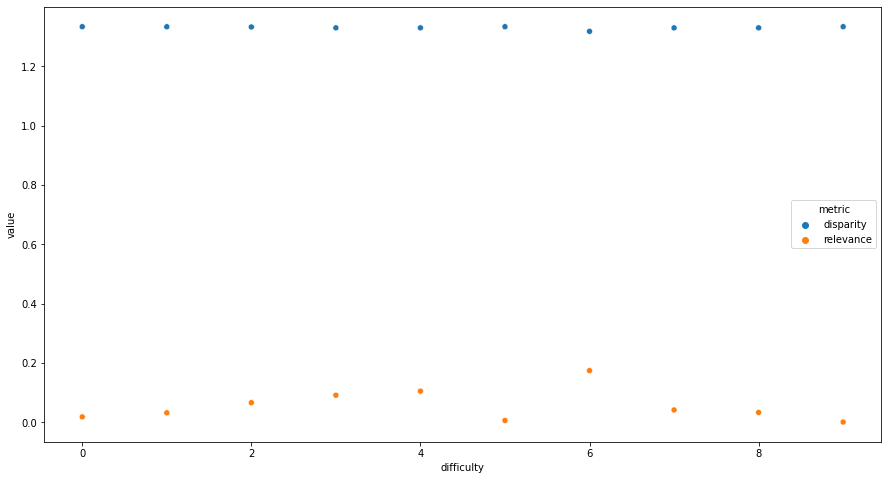

In [73]:
dif_disp_rel = eeli.sort_values(by='difference',ascending=False)[:10].reset_index(drop=True).reset_index().rename({'index':'difficulty'}, axis=1)
disp = dif_disp_rel[["difficulty","disparity"]].rename({'disparity':'value'}, axis=1)
relp = dif_disp_rel[["difficulty","relevance"]].rename({'relevance':'value'}, axis=1)
concatenated = pd.concat([disp.assign(metric='disparity'), relp.assign(metric='relevance')])
print(concatenated.head())

fig, ax = plt.subplots(1,1,figsize = (15,8))
# ax2 = ax.twinx()

pi = iter(sns.color_palette())
f = next(pi)
s = next(pi)

sns.scatterplot(data=concatenated, x='difficulty', y='value',hue='metric',ax=ax)



# fig.suptitle('Relevance and disparity versus difficulty')

In [83]:
concatenated.reset_index(drop=True)

key,difficulty,value,metric
0,0,1.333318,disparity
1,1,1.333089,disparity
2,2,1.332356,disparity
3,3,1.329427,disparity
4,4,1.329412,disparity
5,5,1.333272,disparity
6,6,1.317693,disparity
7,7,1.329396,disparity
8,8,1.329427,disparity
9,9,1.333318,disparity


<AxesSubplot:xlabel='difficulty', ylabel='value'>

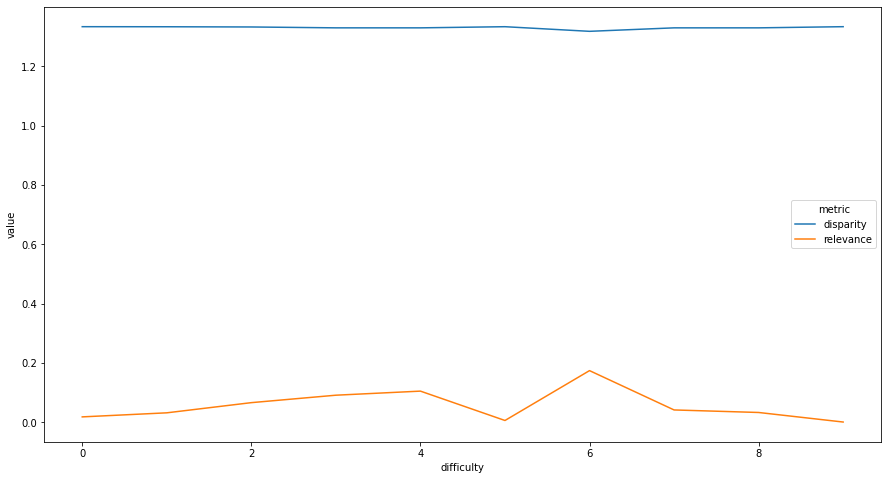

In [84]:
fig, ax = plt.subplots(1,1,figsize = (15,8))

sns.lineplot(x='difficulty', y='value',data=concatenated.reset_index(drop=True),hue='metric',ax=ax)

In [96]:
t = eeli.sort_values(by='difference',ascending=False)[:10].reset_index(drop=True).reset_index()
t

key,index,qid,difference,disparity,relevance
0,0,30631,2.078018,1.333318,0.018709
1,1,12096,2.050381,1.333089,0.032390
2,2,8940,1.982009,1.332356,0.066663
3,3,31412,1.928092,1.329427,0.091752
4,4,12828,1.901233,1.329412,0.105494
5,5,64062,1.761130,1.333272,0.006563
6,6,70673,1.750832,1.317693,0.174576
7,7,3462,1.686219,1.329396,0.042079
8,8,10795,1.617208,1.329427,0.033540
9,9,51432,1.552820,1.333318,0.001357


<AxesSubplot:>

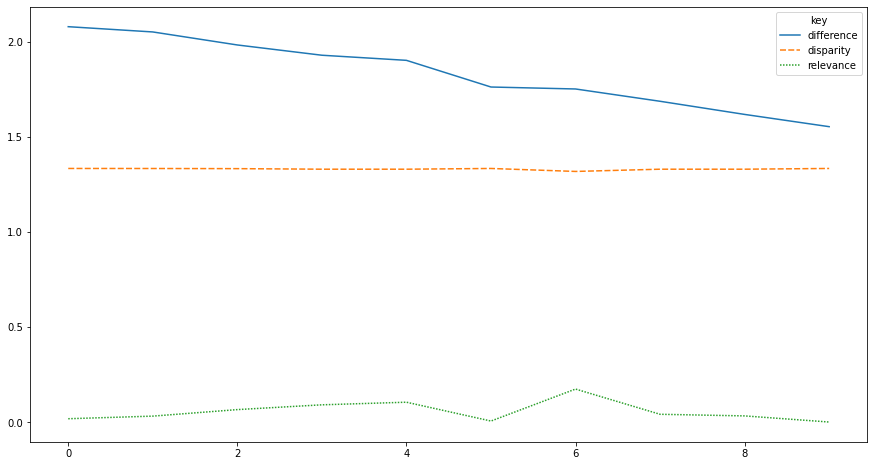

In [100]:
fig, ax = plt.subplots(1,1,figsize = (15,8))

sns.lineplot(data=t[['difference','disparity','relevance']],ax=ax)

<AxesSubplot:>

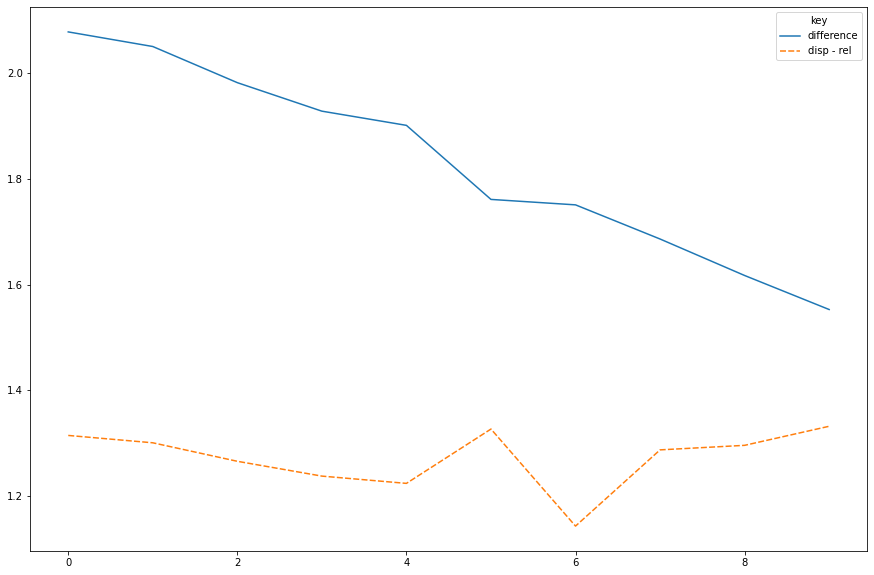

In [104]:
t = eeli.sort_values(by='difference',ascending=False)[:10].reset_index(drop=True).reset_index()
t['disp - rel'] = t.apply(lambda row: row.disparity - row.relevance, axis = 1)
fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.lineplot(data=t[['difference','disp - rel']],ax=ax)

key  difficulty     value     metric
0             0  1.669194  disparity
1             1  3.371439  disparity
2             2  3.870164  disparity
3             3  2.388265  disparity
4             4  1.566086  disparity


Text(0.5, 0.98, 'Relevance and disparity versus difficulty')

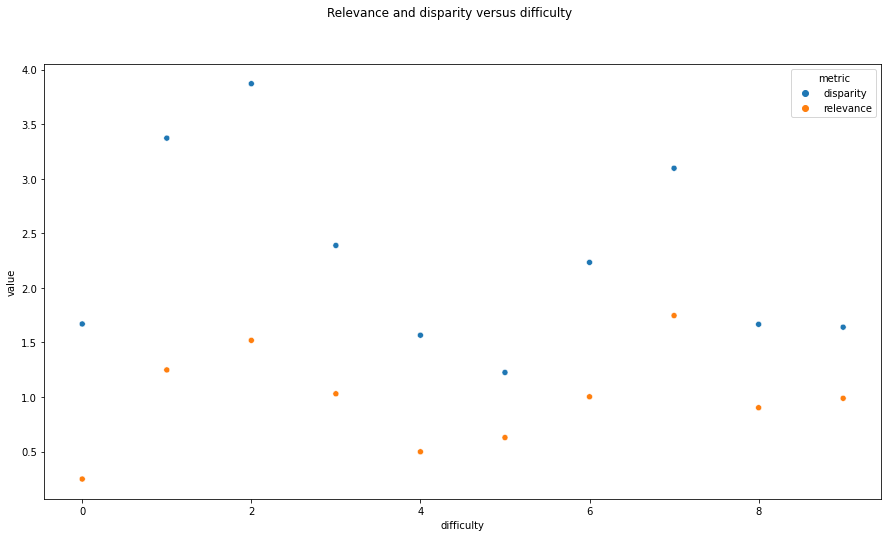

In [98]:
dif_disp_rel = eelh.sort_values(by='difference',ascending=False)[:10].reset_index(drop=True).reset_index().rename({'index':'difficulty'}, axis=1)
disp = dif_disp_rel[["difficulty","disparity"]].rename({'disparity':'value'}, axis=1)
relp = dif_disp_rel[["difficulty","relevance"]].rename({'relevance':'value'}, axis=1)
concatenated = pd.concat([disp.assign(metric='disparity'), relp.assign(metric='relevance')])
print(concatenated.head())

fig, ax = plt.subplots(1,1,figsize = (15,8))
# ax2 = ax.twinx()

pi = iter(sns.color_palette())
f = next(pi)
s = next(pi)

sns.scatterplot(data=concatenated, x='difficulty', y='value',hue='metric',ax=ax)



fig.suptitle('Relevance and disparity versus difficulty')

<AxesSubplot:xlabel='difficulty', ylabel='value'>

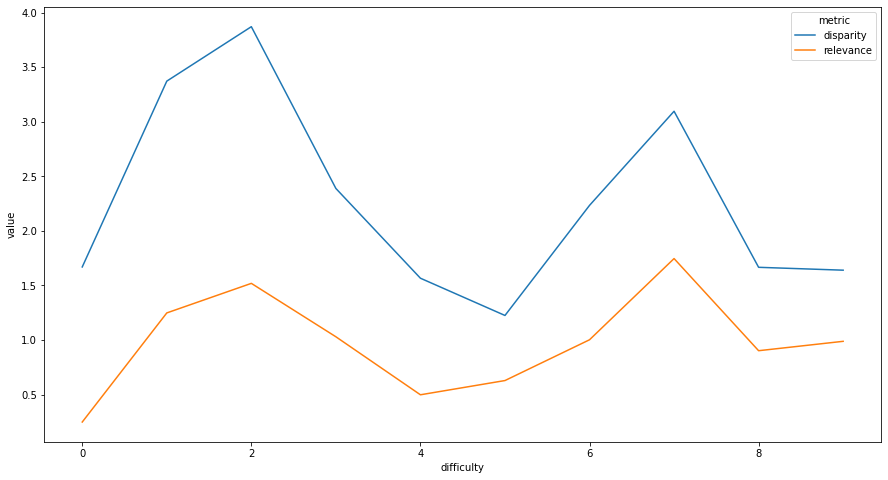

In [99]:
fig, ax = plt.subplots(1,1,figsize = (15,8))

sns.lineplot(x='difficulty', y='value',data=concatenated.reset_index(drop=True),hue='metric',ax=ax)

In [62]:
fig, ax = plt.subplots(1,1,figsize = (15,8))

sns.lineplot(data=t[['difference','disparity','relevance']],ax=ax)

key,index,qid,difference,disparity,relevance
0,0,67404,0.010388,1.775892,1.736097
1,1,66637,0.011306,2.150781,1.995850
2,2,54003,0.137689,3.004248,2.361411
3,3,12096,0.177724,2.823221,2.189027
4,4,120668,0.288219,1.484601,1.157862
5,5,12073,0.384085,1.385029,0.831051
6,6,10795,0.464798,2.266611,1.505607
7,7,49766,0.510208,1.134553,0.632061
8,8,70673,0.526231,1.541967,0.970678
9,9,3462,0.577116,2.792294,1.664274


<AxesSubplot:>

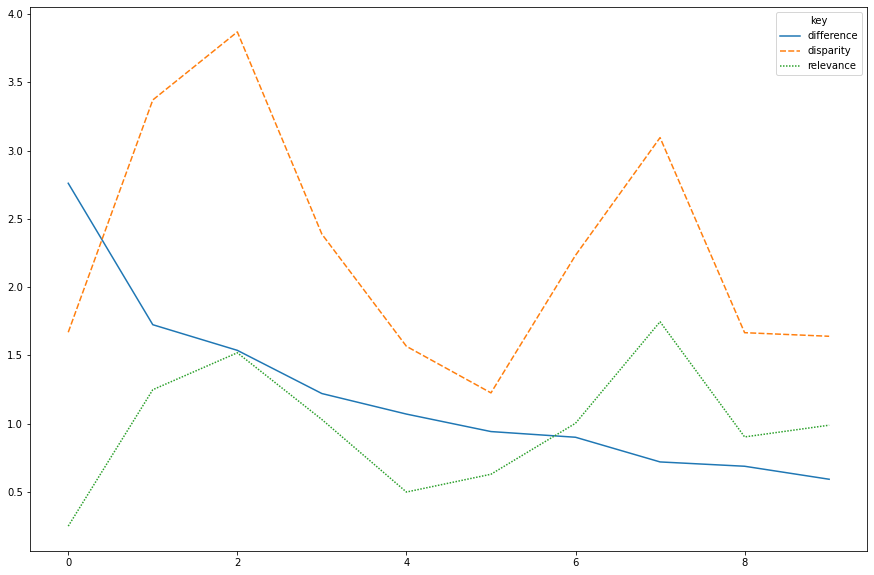

In [102]:
t = eelh.sort_values(by='difference',ascending=False)[:10].reset_index(drop=True).reset_index()
fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.lineplot(data=t[['difference','disparity','relevance']],ax=ax)

Text(0.5, 0, 'difficulty')

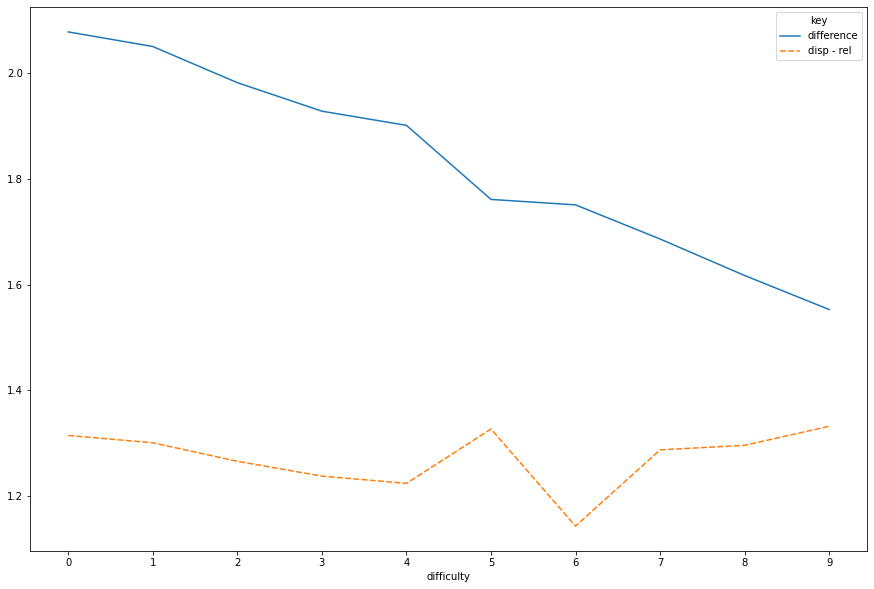

In [110]:
t = eeli.sort_values(by='difference',ascending=False)[:10].reset_index(drop=True).reset_index()
t['disp - rel'] = t.apply(lambda row: row.disparity - row.relevance, axis = 1)
fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.lineplot(data=t[['difference','disp - rel']],ax=ax)
plt.xticks(np.arange(0, 10, 1.0))
ax.set_xlabel('difficulty')

Text(0.5, 0, 'difficulty')

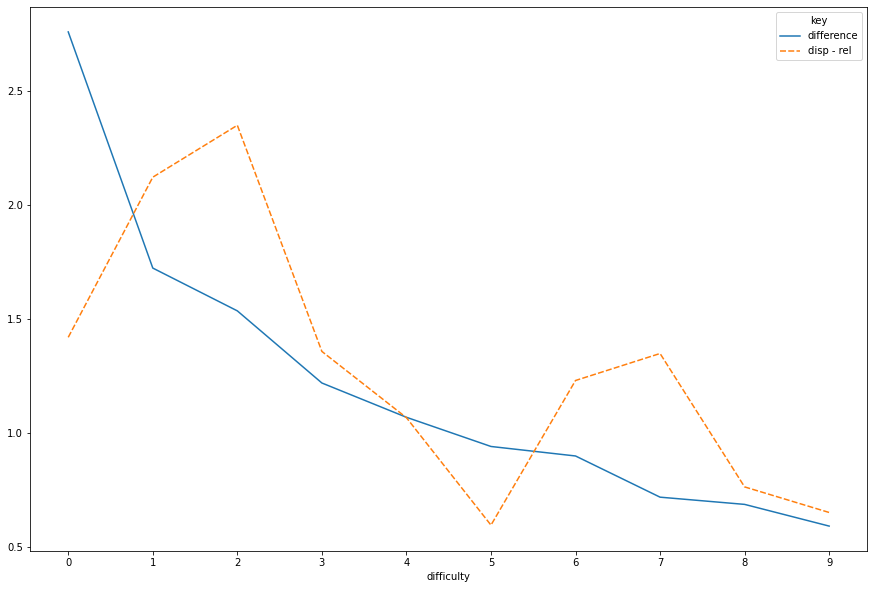

In [109]:
t = eelh.sort_values(by='difference',ascending=False)[:10].reset_index(drop=True).reset_index()
t['disp - rel'] = t.apply(lambda row: row.disparity - row.relevance, axis = 1)
fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.lineplot(data=t[['difference','disp - rel']],ax=ax)
plt.xticks(np.arange(0, 10, 1.0))
ax.set_xlabel('difficulty')

## 6. What obvious mistakes did the system make that it could have easily avoided?


## 7. Other features of note.


- what are the other feature values of the top documents?

- many of the difficult queries about covid
- most queries short
- maybe inCitations should not count...

## 8. What added information would help performance? How can the system get that information?

- Does not incorporate grouping information at all, could be useful



## 9. Are there differences between the official assessment of documents and your own assessment?

- There are many differences. Often things are marked as relevant when they are not to me or vice versa. May be because the 

# Bibliography

[1] Buckley, ‘Reliable Information Access Final Workshop Report’.